In [58]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import aiohttp     
import asyncio
import requests
import time
from datetime import datetime
import json
import os
import re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report,confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from scipy.stats import uniform, randint
 
 

In [59]:
%matplotlib inline
warnings.filterwarnings('ignore')

# Predicting LeBron James Points Props - October 22nd

##### Defined some helper functions as framework to pull from specific endpoints. Goal here is setting the grounds for replicability #####
### Helper Functions I used for Data Collection
- `get_team_id(session, team)`: Fetches the team ID for a given team name.
- `get_player_id(session, team, player_name)`: Fetches the player ID for a given player name and team.
- `async def get_game_ids(session,team_id,szn,start_year,end_year=None):`: Retrieves game IDs across specified seasons for a team for a specified year range.
- `get_seasonal_stats(session, team_id, year)`: Returns player stats by team for a season
- `async def get_coach(session, team_id)`: Returns the current coach roster for given team_id
- `async def get_roster(session,team_id):`: Returns current team roster

##### Bulkier looped calls saves JSON output to local directory (lowering requests due to trial version of API)

In [60]:
async def get_team_id(session,team):
    url = "https://api.sportradar.com/nba/trial/v8/en/league/teams.json?api_key=L4hsPTYE3VWFLrddbvF1S49IG61zqJy15NK3ZNL7"
    headers = {"accept": "application/json"}

    async with session.get(url,headers=headers) as response:
        if response.status == 200:
            nba_data = await response.json() 
            team_id = next((teams['id'] for teams in nba_data['teams'] if teams['name'] == team),None)
            return team_id
        elif response.status == 429:
             retry_window = int(response.headers.get('Retry-After', 15))  
             await asyncio.sleep(retry_window)
        else:
            print(f"Desired NBA team does not exist. Status: {response.status}")
            return None
        
async def get_player_id(session,team_id,player_name):
    url = f"https://api.sportradar.com/nba/trial/v8/en/teams/{team_id}/profile.json?api_key=L4hsPTYE3VWFLrddbvF1S49IG61zqJy15NK3ZNL7"
    headers = {"accept": "application/json"}

    async with session.get(url,headers=headers) as response:
        if response.status == 200:
            team_data = await response.json()
            player_id = next((player['id'] for player in team_data['players'] if player['full_name'] == player_name),None)
            return player_id
        elif response.status == 429:
            retry_window = int(response.headers.get('Retry-After', 15))  
            await asyncio.sleep(retry_window)
        else:
            print(f"Desired player does not exist. Status: {response.status}")
            return None
        
async def get_game_ids(session,team_id,szn,start_year,end_year=None):
    if end_year is None:
        end_year = start_year
    if start_year > end_year or end_year > datetime.now().year:
        raise ValueError(f"Invalid year range: start_year={start_year}, end_year={end_year}. Check that start_year <= end_year and end_year <= {datetime.now().year}.")
     
    game_id = {}
    for year in range(start_year,end_year+1):

        url = f"https://api.sportradar.com/nba/trial/v8/en/games/{year}/{szn}/schedule.json?api_key=L4hsPTYE3VWFLrddbvF1S49IG61zqJy15NK3ZNL7"
        headers = {"accept": "application/json"}
        
        #add game_id to game_id list
        async with session.get(url,headers=headers) as response:
            if response.status == 200:
                schedule = await response.json()
                if not schedule['games']:
                    print(f"{szn} season has not started in {year}")
                    continue
        
                team_games = [game['id'] for game in schedule['games'] if game['home']['id'] == team_id or game['away']['id'] == team_id]
                if team_games:
                    if not os.path.exists('game_ids'):
                        os.makedirs('game_ids')
                    with open(f'game_ids/{szn}_{team_id}_{year}.json', 'w') as f:
                        json.dump({'games': team_games}, f)
                    print(f"Saved {len(team_games)} games for {team_id} in {year}")
                else:
                    print(f"No games found for {team_id}'s in {year}")
    return game_id
    
async def get_seasonal_stats(session,team_id,year):  
    if not team_id:
        return "No Team ID provided or found"
    if not year: #default to last season
        year = datetime.now().year - 1

    team_data = []
    url = f"https://api.sportradar.com/nba/trial/v8/en/seasons/{year}/REG/teams/{team_id}/statistics.json?api_key=L4hsPTYE3VWFLrddbvF1S49IG61zqJy15NK3ZNL7"
    headers = {"accept": "application/json"}

    while True:
        async with session.get(url,headers=headers) as response:
            if response.status == 200:
                team_season_data = await response.json()
                team_data.append(team_season_data) 
                break;    
            if response.status == 429:
                retry_window = int(response.headers.get('Retry-After', 15))  
                await asyncio.sleep(retry_window)
            else:
                print(f"Failed to fetch stats for year {year}. Status: {response.status}")
                return None                
    return team_data

async def get_coach(session, team_id): #only gets current day coach from the team enpoind (doesn't work as intended....oops)
    url = f"https://api.sportradar.com/nba/trial/v8/en/teams/{team_id}/profile.json?api_key=L4hsPTYE3VWFLrddbvF1S49IG61zqJy15NK3ZNL7"
    headers = {"accept": "application/json"}
    
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            team_data = await response.json()
            coach = next((coach for coach in team_data['coaches'] if coach['position'].lower() == 'head coach'), None)
            if coach:
                return {
                    "coach_id": coach.get('id'),
                    "coach_name": coach.get('full_name'),
                    "experience": coach.get('experience', 0)
                }
            else:
                return {
                    "coach_id": None,
                    "coach_name": None,
                    "experience": None
                }
        elif response.status == 429:
            retry_window = int(response.headers.get('Retry-After', 15))  
            await asyncio.sleep(retry_window)
            return await get_coach(session, team_id)  
        else:
            print(f"Failed to fetch coach data")
            return None

async def get_roster(session,team_id):
    url = f"https://api.sportradar.com/nba/trial/v8/en/teams/{team_id}/profile.json?api_key=L4hsPTYE3VWFLrddbvF1S49IG61zqJy15NK3ZNL7"
    headers = {"accept": "application/json"}
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            team_data = await response.json()
            return team_data['players']
        elif response.status == 429:
            retry_window = int(response.headers.get('Retry-After', 15))  
            await asyncio.sleep(retry_window)
            return await get_roster(session, team_id)
        else:
            print(f"Failed to fetch roster data. Status: {response.status}")
            return None
 

 



### Data Collection Functions 
- `player_team_contribution(team, year)`: Calculates a player's contribution to the team's total metrics and returns a DataFrame of proportions.
- `fetch_game(session, game_id)`: fetches specific game given game_id 
- `fetch_all_games(game_ids, team):`:  concurrently fetch all games given game_id list. May run into API rate limiting (at least on trial access lvl), ease with caution.

In [61]:
 
async def player_team_contribution(team,year):
      async with aiohttp.ClientSession() as session: 
        team_id = await get_team_id(session,team)
        if team_id:
            seasonal_stats = await get_seasonal_stats(session,team_id,year)
            if seasonal_stats:
                for season in seasonal_stats:
                    player_stats = {}
                    for player in season['players']:
                        player_stats[player['full_name']] = player['total']
                        player_contribution = {k: round(v/season['own_record']['total'][k],2) if season['own_record']['total'][k] != 0 else 0 for k, v in player['total'].items() if k in season['own_record']['total']}
                        player_stats[player['full_name']].update(player_contribution)

                    df = pd.DataFrame(player_stats).T
                    df = df.loc[:,(df.max() <= 1)]
                    df.insert(0,'Year',year)
                    return df.sort_values(by='minutes',ascending=False)
            else:
                return "No stats found."
            
async def fetch_game(session, game_id):
    url = f"https://api.sportradar.com/nba/trial/v8/en/games/{game_id}/summary.json?api_key=L4hsPTYE3VWFLrddbvF1S49IG61zqJy15NK3ZNL7"
    headers = {"accept": "application/json"}
    try:
        async with session.get(url, headers=headers) as response:
            if response.status == 200:
                game_data = await response.json()
                return game_data 
            elif response.status == 429:
                retry_window = int(response.headers.get('Retry-After', 15))  
                await asyncio.sleep(retry_window) 
                return await fetch_game(session, game_id)  
            else:
                print(f"Failed to fetch game stats for game {game_id}. Status: {response.status}")
                return None 
    except Exception as e:
        print(f"Error fetching game {game_id}: {e}")
        return None  

async def fetch_all_games(game_ids,szn,team): #manually passed team name for easier tracking purposes
    async with aiohttp.ClientSession() as session:  
        tasks = []
        all_game_data = []
        seasons_to_process = game_ids if isinstance(game_ids, list) else [game_ids]
        for season in seasons_to_process:
            print(season)
            year = season['year']
            for game_id in season['games']:
                tasks.append(fetch_game(session, game_id))  
            games = await asyncio.gather(*tasks)
            tasks.clear()         
            valid_games = [game for game in games if game is not None]
            all_game_data.extend(valid_games)  

            if not os.path.exists('game_data'):
                os.makedirs('game_data')
            with open(f'game_data/{szn}_{team}_{year}.json', 'w') as f:
                json.dump({'games': valid_games}, f) 
        return f"Saved"

 
#ignore this, realized too late that the structure of the teams endpoint call doesn't work for this coach:expereince mapping
async def create_coach_df(games,year):
    tasks = []   
    async with aiohttp.ClientSession() as session:
        for game in games['games']:
            game_id = game.get('id', None)
            team_id_h = game['home'].get('id', None)
            team_id_a = game['away'].get('id', None)

            if game['home'].get('coaches'):
                tasks.append(get_coach(session, game_id, team_id_h))
            if game['away'].get('coaches'):
                tasks.append(get_coach(session, game_id, team_id_a))
        coaches = {}
        coach_data = await asyncio.gather(*tasks)
        for coach in coach_data:
            if coach and coach['coach_id']:
                game_id = coach['game_id']
                coach_id = coach['coach_id']
                coach_name = coach['coach_name']
                if game_id not in coaches: #optimal bc of limited api calls, i want to build the coach data for reference later
                    coaches[game_id] = {}
                coaches[game_id][coach_id] = coach
                coaches[game_id][coach_name] = coach

        if not os.path.exists('data_exploration'):
            os.makedirs('data_exploration')
        with open(f'data_exploration/coach_data_{year}.json', 'w') as f:
            json.dump(coaches, f, indent=4)
        return f"Saved"



# Initial Exploration + Data Collection #


In [62]:
#get_team_id(session,'Lakers')
#lakers_id = 583ecae2-fb46-11e1-82cb-f4ce4684ea4c

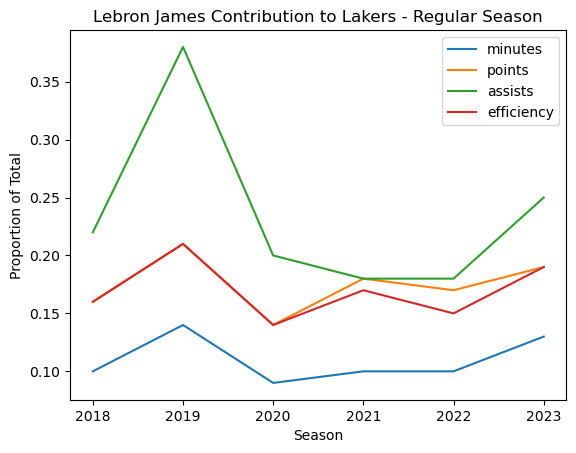

In [63]:
# tasks = [player_team_contribution("Lakers", year) for year in range(2018, 2024)]
# season_range = await asyncio.gather(*tasks)
# df = pd.concat(season_range, axis=0)
# if not os.path.exists('data_exploration'):
#     os.makedirs('data_exploration')
#df.to_csv('data_exploration/lebron_contribution_DE.csv')
df = pd.read_csv('data_exploration/lebron_contribution_DE.csv',index_col=0)

lebron_trend = df.loc['LeBron James'] 
plt.plot(lebron_trend['Year'],lebron_trend['minutes'])
plt.plot(lebron_trend['Year'],lebron_trend['points'])
plt.plot(lebron_trend['Year'],lebron_trend['assists'])
plt.plot(lebron_trend['Year'],lebron_trend['efficiency'])
plt.xlabel('Season')
plt.ylabel('Proportion of Total')
plt.legend(['minutes','points','assists','efficiency'])
plt.title('Lebron James Contribution to Lakers - Regular Season')
plt.show()


#### Divergence Between Points and Efficiency

The divergence between point contribution and efficiency contribution can be attributed to many factors. With AD out for a good portion of the season, LeBron had to carry more offesnvive burden during this time, and likely had increased scoring attempts under pressure and increased his iso-plays, which points to less efficiency due to greater defensive pressure. In addition, LeBron coming back from his own ankle injury during this time probably led to subsequent drop in season-wide efficiency contribution as well. 

Towards the present, we see an increase in assist contribution again. Notice that assist contribution increases more dramatically than points contribution up until the present. LeBron may be filling more of the veteran playmaker and leadership role now and focusing less on scoring and more on assisting younger teammates. If this trend over time is quantifiable through the data I pull, it will be factored into my model.

 


### Deeper Dive into LeBron's Scoring Trend (Lakers-Present)

- **Setting + Context**: I am choosing the starting point of this data pull from LeBron's Lakers debut to capture most recent trends on his role on his current team over the more recent years. I only select regular season game to match the intensity of the predictive game setting
- **Assumptions**: 1. 2020-21 pandemic season has variability casued by differences in scheduling, crowd-presence, etc. I will remove 2020 from the analysis. I want to pull more recent data to introduce less noise from the past when he played for the Cavs or the Heat, even if LeBron has been a consistent scorer prior to the Lakers

Because we are predicting in a specific context - opening game, against the wolves, new head coach, I want to bias my model to weigh these conditions from historic data.

In [64]:
#run these api calls below once to get the game_ids saved in the game_ids folder
async with aiohttp.ClientSession() as session:
    #await get_game_ids(session,'583ecae2-fb46-11e1-82cb-f4ce4684ea4c','REG',2018,2023)
    #await get_game_ids(session,'583ecae2-fb46-11e1-82cb-f4ce4684ea4c','PRE',2018,2023) #preseason 

    game_ids = {'REG': [], 'PRE': []}
    for file in os.listdir('game_ids'):
        with open(f'game_ids/{file}') as f:
            data = json.load(f)
            year = int(file.split('_')[-1].split('.')[0])
            if 'PRE' in file:
                game_ids['PRE'].append({'year': year, 'games': data['games']})
            else:
                game_ids['REG'].append({'year': year, 'games': data['games']})

    game_ids['REG'] = sorted(game_ids['REG'], key=lambda x: x['year'])
    game_ids['PRE'] = sorted(game_ids['PRE'], key=lambda x: x['year'])

In [65]:
#ensure no null game_ids in any season
for games in game_ids['REG']:
    if not games['games']:
        print(f"Missing game_ids for {games}")
        break

for games in game_ids['PRE']:
    if not games['games']:
        print(f"Missing game_ids for {games}")
        break

feeding game_id list into fetch_all_games function to get game stats to be saved in game_stats folder (run just once to avoid re-calling API)


In [66]:
#async with aiohttp.ClientSession() as session:
     #await fetch_all_games(game_ids['REG'],'REG', 'Lakers') #naming purposes for clarity
     #await fetch_all_games(game_ids['PRE'], 'PRE', 'Lakers')

In [67]:
#find how many games were saved for each file in game_data folder
game_data = []
for file in os.listdir('game_data'):
    with open(f'game_data/{file}') as f:
        game_data.append(json.load(f))
        print(f"Saved {len(game_data[-1]['games'])} games for {file}")


Saved 6 games for PRE_Lakers_2018.json
Saved 6 games for PRE_Lakers_2019.json
Saved 4 games for PRE_Lakers_2020.json
Saved 6 games for PRE_Lakers_2021.json
Saved 6 games for PRE_Lakers_2022.json
Saved 6 games for PRE_Lakers_2023.json
Saved 6 games for PRE_Lakers_2024.json
Saved 82 games for REG_Lakers_2018.json
Saved 91 games for REG_Lakers_2019.json
Saved 72 games for REG_Lakers_2020.json
Saved 82 games for REG_Lakers_2021.json
Saved 82 games for REG_Lakers_2022.json
Saved 82 games for REG_Lakers_2023.json


Lets take out the "bubble" season 2019-2020 to limit potential outlier-like situations that would impact variability. The rest of the seasons looks about right.

In [68]:
#lakers_id = '583ecae2-fb46-11e1-82cb-f4ce4684ea4c'
#timberwolves_id ='583eca2f-fb46-11e1-82cb-f4ce4684ea4c'

#run commented section once to load roster onto local device.
# async with aiohttp.ClientSession() as session:
#     lakers_roster = await get_roster(session, '583ecae2-fb46-11e1-82cb-f4ce4684ea4c')
#     wolves_roster = await get_roster(session, '583eca2f-fb46-11e1-82cb-f4ce4684ea4c')

#     if not os.path.exists('roster_data'):
#         os.makedirs('roster_data')

#     with open('roster_data/lakers_roster.json', 'w') as f:
#         json.dump(lakers_roster, f, indent=4)
#     with open('roster_data/wolves_roster.json', 'w') as f:
#         json.dump(wolves_roster, f, indent=4)

with open('roster_data/lakers_roster.json') as f:
    lakers_roster = json.load(f)
    print("Lakers Roster:")
    for player in lakers_roster[:5]:
        print(player['full_name'])

with open('roster_data/wolves_roster.json') as f:  
    wolves_roster = json.load(f)
    print("\nTimberwolves Roster:")
    for player in wolves_roster[:5]:
        print(player['full_name'])

Lakers Roster:
Kylor Kelley
LeBron James
Jarred Vanderbilt
Jordan Goodwin
Gabe Vincent

Timberwolves Roster:
Jesse Edwards
Julius Randle
Terrence Shannon Jr.
Rudy Gobert
Mike Conley


# Dataset Building + Considering Features
I ended up building out a dataset using different API pulls and added some binary flag columns, but I will touch on that in the later section - this data structure I am creating ahead of time will allow me to flexibly explore some relationships between different variables in the data as a continuation to data exploration step. I am pulling as many features as I deem fit, and will narrow down during feature selection and engineer/remove some features

Every row in this dataset I build involves a game LeBron has presence in (I keep LeBron in rows when he is DnP due to injury or whatever reason, as duration between games and long durations is important context). I created a game-wide flag for whether the game was played against the wolves, whether the game played was the first of the season, whether the game was preseason or regular, and a player flag that keeps track of whether a player from the past is currently on the Wolves' roster. I also created a rolling_win_rate to try and capture momentum from teams that are on a streak and are crushing it. Other environmental factors (however small) that could shift the outcome of these games in certain ways - I include stadium attendance (too bad there is no measure for loudness), game official experience, and coaches.

I wanted to get coach expereince aggregates in years, as JJ redick is new. I realized the API endpoint I was looking at only stores most recent coach data for a team, and didn't have a field for experience at the time of the game. For now, I am going to quantify coaching changes over the years by pulling in coach_id's for the model to categorize. It will not be as effective as a scale representation of numeric expereince in years, but it is an area I want to consider.

In [69]:
game_stats = []  
with open('roster_data/wolves_roster.json', 'r') as f:
    wolves_roster = json.load(f)
    if isinstance(wolves_roster, list):
        wolves_player_ids = {player['id'] for player in wolves_roster if 'id' in player}
    else:
        wolves_player_ids = set()

for year in range(2018, 2024 + 1):
    if year == 2019:
        continue  # No data for 2019 season
    game_data = {'games': []}
    try:
        with open(f'game_data/PRE_Lakers_{year}.json', 'r') as pre_f:
            pre_game_data = json.load(pre_f)
            game_data['games'].extend(pre_game_data['games'])
    except FileNotFoundError:
        pass
    
    try:
        with open(f'game_data/REG_Lakers_{year}.json', 'r') as reg_f:
            reg_game_data = json.load(reg_f)
            game_data['games'].extend(reg_game_data['games'])
    except FileNotFoundError:
        pass

    for game in game_data['games']:

        game_id = game.get('id', None)

        season_type = game.get('season', {}).get('type', '').lower()
        regular_szn = 0 if season_type == 'pre' else 1

        attendance = game.get('attendance', None)
        timbs = '583eca2f-fb46-11e1-82cb-f4ce4684ea4c'
        # if game['home']['coaches'] is not a field in the json, then the coach is not available
        coach_id_h = next((coach for coach in game['home'].get('coaches', []) if coach.get('position', '').lower() in ('interim head coach', 'head coach')), None)
        coach_id_a = next((coach for coach in game['away'].get('coaches', []) if coach.get('position', '').lower() in ('interim head coach', 'head coach')), None)

        date = game.get('scheduled', None) 
        date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S+00:00') if date else None

        rolling_win_rate_a = None
        rolling_win_rate_h = None
        if 'record' in game['home']:
            wins = game['home']['record'].get('wins', 0)
            losses = game['home']['record'].get('losses', 0)
            rolling_win_rate_h = wins / (wins + losses) if wins + losses > 0 else None
        if 'record' in game['away']:
            wins = game['away']['record'].get('wins', 0)
            losses = game['away']['record'].get('losses', 0)
            rolling_win_rate_a = wins / (wins + losses) if wins + losses > 0 else None

        if 'statistics' in game['home']: team_stats_h = {f"{k}_team": v for k, v in game['home']['statistics'].items() if k != 'periods'}
        if 'statistics' in game['away']: team_stats_a = {f"{k}_team": v for k, v in game['away']['statistics'].items() if k != 'periods'}

        wolves_flag = 1 if game['home']['id'] == timbs or game['away']['id'] == timbs else 0

        game_official = next((official for official in game['officials'] if official.get('assignment', '').lower() in ('head official')), None)
        
        if game['home']['name'] == 'Lakers':
            for player in game['home']['players']:
                player_stats = {
                    'season_start': year,
                    'regular_szn': regular_szn,
                    'game_dt': date,
                    'game_id': game_id,
                    'game_officials_exp': game_official.get('experience', 0) if game_official else 0,
                    'player_id': player['id'],
                    'name': player['full_name'],
                    'position': player.get('position', None),
                    'team_id_h': game['home']['id'],
                    'team_id_a': game['away']['id'],
                    'lakers': 1,
                    'wolves': wolves_flag,
                    'current_wolves': 1 if player['id'] in wolves_player_ids else 0,
                    'home': 1,
                    'time_zone': game.get('time_zones', {}).get('home', None),
                    'attendance': attendance,
                    'coach_id': coach_id_h.get('id') if coach_id_h else None,
                    'coach_name': coach_id_h.get('full_name') if coach_id_h else None,
                    'playing': 0 if player['statistics']['minutes'] == '00:00' else 1,
                    'rolling_win_rate': rolling_win_rate_h
                }
                if 'statistics' in player:
                    player_stats.update({k: v for k, v in player['statistics'].items() if k != 'periods'})
                    player_stats.update(team_stats_h)
                game_stats.append(player_stats)

            for player in game['away']['players']:
                player_stats = {
                    'season_start': year,
                    'regular_szn': regular_szn,
                    'game_dt': date,
                    'game_id': game_id,
                    'game_officials_exp': game_official.get('experience', 0) if game_official else 0,
                    'player_id': player['id'],
                    'name': player['full_name'],
                    'position': player.get('position', None),
                    'team_id_h': game['home']['id'],
                    'team_id_a': game['away']['id'],
                    'lakers': 0,
                    'wolves': wolves_flag,
                    'current_wolves': 1 if player['id'] in wolves_player_ids else 0,
                    'home': 0,
                    'time_zone': game.get('time_zones', {}).get('away', None),
                    'attendance': attendance,
                    'coach_id': coach_id_a.get('id') if coach_id_a else None,
                    'coach_name': coach_id_a.get('full_name') if coach_id_a else None,
                    'playing': 0 if player['statistics']['minutes'] == '00:00' else 1,
                    'rolling_win_rate': rolling_win_rate_a
                }
                if 'statistics' in player:
                    player_stats.update({k: v for k, v in player['statistics'].items() if k != 'periods'})
                    player_stats.update(team_stats_a)
                game_stats.append(player_stats)

        elif game['away']['name'] == 'Lakers':
            for player in game['away']['players']:
                player_stats = {
                    'season_start': year,
                    'regular_szn': regular_szn,
                    'game_dt': date,
                    'game_id': game_id,
                    'game_officials_exp':  game_official.get('experience', 0) if game_official else 0,
                    'player_id': player['id'],
                    'name': player['full_name'],
                    'position': player.get('position', None),
                    'team_id_h': game['home']['id'],
                    'team_id_a': game['away']['id'],
                    'lakers': 1,
                    'wolves': wolves_flag,
                    'current_wolves': 1 if player['id'] in wolves_player_ids else 0,
                    'home': 0,
                    'time_zone': game.get('time_zones', {}).get('away', None),
                    'attendance': attendance,
                    'coach_id': coach_id_a.get('id') if coach_id_a else None,
                    'coach_name': coach_id_a.get('full_name') if coach_id_a else None,
                    'playing': 0 if player['statistics']['minutes'] == '00:00' else 1,
                    'rolling_win_rate': rolling_win_rate_a
                }
                if 'statistics' in player:
                    player_stats.update({k: v for k, v in player['statistics'].items() if k != 'periods'})
                player_stats.update(team_stats_a)
                game_stats.append(player_stats)

            for player in game['home']['players']:
                player_stats = {
                    'season_start': year,
                    'regular_szn': regular_szn,
                    'game_dt': date,
                    'game_id': game_id,
                    'game_officials_exp': game_official.get('experience', 0) if game_official else 0,
                    'player_id': player['id'],
                    'name': player['full_name'],
                    'position': player.get('position', None),
                    'team_id_h': game['home']['id'],
                    'team_id_a': game['away']['id'],
                    'lakers': 0,
                    'wolves': wolves_flag,
                    'current_wolves': 1 if player['id'] in wolves_player_ids else 0,
                    'home': 1,
                    'time_zone': game.get('time_zones', {}).get('home', None),
                    'attendance': attendance,
                    'coach_id': coach_id_h.get('id') if coach_id_h else None,
                    'coach_name': coach_id_h.get('full_name') if coach_id_h else None,
                    'playing': 0 if player['statistics']['minutes'] == '00:00' else 1,
                    'rolling_win_rate': rolling_win_rate_h
                }
                if 'statistics' in player:
                    player_stats.update({k: v for k, v in player['statistics'].items() if k != 'periods'})
                    player_stats.update(team_stats_h)
                game_stats.append(player_stats)

all_game_stats_df = pd.DataFrame(game_stats)
all_game_stats_df.to_csv('data_exploration/base_data.csv', index=False)


### Reading results of the data-pull

In [70]:
df = pd.read_csv('data_exploration/base_data.csv', index_col=0)

df.head()

,regular_szn,game_dt,game_id,game_officials_exp,player_id,name,position,team_id_h,team_id_a,lakers,wolves,current_wolves,home,time_zone,attendance,coach_id,coach_name,playing,rolling_win_rate,minutes,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,tech_fouls,flagrant_fouls,pls_min,points,tech_fouls_non_unsportsmanlike,double_double,triple_double,effective_fg_pct,efficiency,efficiency_game_score,fouls_drawn,offensive_fouls,points_in_paint,points_in_paint_att,points_in_paint_made,points_in_paint_pct,points_off_turnovers,true_shooting_att,true_shooting_pct,coach_ejections,coach_tech_fouls,second_chance_pts,second_chance_pct,fast_break_pts,fast_break_att,fast_break_made,fast_break_pct,defensive_rating,offensive_rating,minus,plus,defensive_rebounds_pct,offensive_rebounds_pct,rebounds_pct,steals_pct,turnovers_pct,second_chance_att,second_chance_made,minutes_team,field_goals_made_team,field_goals_att_team,field_goals_pct_team,three_points_made_team,three_points_att_team,three_points_pct_team,two_points_made_team,two_points_att_team,two_points_pct_team,blocked_att_team,free_throws_made_team,free_throws_att_team,free_throws_pct_team,offensive_rebounds_team,defensive_rebounds_team,assists_team,steals_team,blocks_team,assists_turnover_ratio_team,personal_fouls_team,ejections_team,foulouts_team,points_team,fast_break_pts_team,second_chance_pts_team,team_turnovers_team,points_off_turnovers_team,team_rebounds_team,flagrant_fouls_team,player_tech_fouls_team,team_tech_fouls_team,coach_tech_fouls_team,points_in_paint_team,team_offensive_rebounds_team,team_defensive_rebounds_team,total_rebounds_team,total_turnovers_team,personal_rebounds_team,player_turnovers_team,field_goals_at_rim_made_team,field_goals_at_rim_att_team,field_goals_at_rim_pct_team,field_goals_at_midrange_made_team,field_goals_at_midrange_att_team,field_goals_at_midrange_pct_team,bench_points_team,biggest_lead_team,effective_fg_pct_team,efficiency_team,efficiency_game_score_team,fouls_drawn_team,offensive_fouls_team,pls_min_team,points_in_paint_att_team,points_in_paint_made_team,points_in_paint_pct_team,total_fouls_team,true_shooting_att_team,true_shooting_pct_team,coach_ejections_team,defensive_rating_team,offensive_rating_team,points_against_team,possessions_team,opponent_possessions_team,time_leading_team,defensive_points_per_possession_team,offensive_points_per_possession_team,team_fouls_team,second_chance_att_team,second_chance_made_team,second_chance_pct_team,fast_break_att_team,fast_break_made_team,fast_break_pct_team,most_unanswered_team
season_start,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018,0,2018-10-01 01:30:00,50d9471c-92cd-4a2c-a152-96c5b8106246,2,4fae86e2-4f99-4247-af85-d917b4389d31,Kyle Kuzma,F,583ecae2-fb46-11e1-82cb-f4ce4684ea4c,583ed102-fb46-11e1-82cb-f4ce4684ea4c,1,0,0,1,US/Pacific,13565.0,1352daff-91ea-49d2-83c6-45fedaf0402a,Luke Walton,1,NaN,24:22,4,13,30.8,2,6,33.3,2,7,28.6,1,5,5,100.0,0,3,3,2,3,1,1,0.67,4,0,0,-13,15,0.0,False,False,38.5,9,6.9,4,0,4,7,2,28.6,0,15.20,49.3,0,0,2,0.0,10,4.0,3.0,75.0,112.837050,87.290227,64.0,51.0,13.742860,0.0,6.792448,1.768232,16.483516,1.0,0.0,4:00:00,40,87,46.0,8,25,32.0,32,62,51.6,5,19,26,73.1,7,30,26,9,7,1.24,31,0,0,107,22,16,0,21,7,0,0,0,0,52,7,0,44,21.0,37,21,21.0,32.0,65.6,6.0,17.0,35.3,61,4,50.6,103,71.9,28,1,-17,45,26,57.8,31,98.44,54.3,0,111.310592,95.161864,124,112.44,111.4,5:12,1.1,0.95,0,7,6,85.7,11,8,72.7,"{'points': 11, 'own_score': 65, 'opp_score': 67}"
2018,0,2018-10-01 01:30:00,50d9471c-92cd-4a2c-a152-96c5b8106246,2,798094cc-74f9-4792-92fb-f6f6cb962766,Travis Wear,F,583ecae2-fb46-11e1-82cb-f4ce4684ea4c,583ed102-fb46-11e

Here I added first_game_flag to track if the game was a first game. I could've also done it during my table creation

In [71]:
regular_season_games = df[df['regular_szn'] == 1]

first_games = regular_season_games.groupby(['season_start'])['game_dt'].min().reset_index()
first_games['first_game_flag'] = 1
df = df.merge(first_games, on=['season_start', 'game_dt'], how='left')

df['first_game_flag'] = df['first_game_flag'].fillna(0).astype(int)
df.set_index('season_start', inplace=True)

df[df['first_game_flag'] == 1][['game_id', 'game_dt']].drop_duplicates()

,game_id,game_dt
season_start,,
2018,e921cc4b-285b-4a94-810d-fb12eb785770,2018-10-19 02:30:00
2020,434e7bf3-7c6e-4433-9e4c-2ab68db626c0,2020-12-23 03:00:00
2021,16b3619b-5b6a-46a1-b70f-6e7ef8b5330f,2021-10-20 02:00:00
2022,c665e441-9f38-48a7-8796-1f7292f97db1,2022-10-19 02:00:00
2023,0343c99e-bd5e-4887-aa21-94875b8dfba3,2023-10-24 23:30:00


##### validation: 428 games makes sense as we removed 2019 season: 82*4 + 72 + 28 (pre szn) = 400

In [72]:
df['game_id'].nunique()

430

In [73]:
categorical_columns = df.select_dtypes(include=['object', 'category','boolean']).columns
print("Categorical columns:", categorical_columns)

Categorical columns: Index(['game_dt', 'game_id', 'player_id', 'name', 'position', 'team_id_h',
       'team_id_a', 'time_zone', 'coach_id', 'coach_name', 'minutes',
       'double_double', 'triple_double', 'minutes_team', 'time_leading_team',
       'most_unanswered_team'],
      dtype='object')


In [74]:
#these booleans converted to numeric
df['double_double'] = df['double_double'].astype(int)
df['triple_double'] = df['triple_double'].astype(int)
df['first_game_flag'] = df['first_game_flag'].astype(int)

In [75]:
def convert_to_minutes(time_str):
    parts = list(map(int, time_str.split(':')))
    if len(parts) == 2: 
        minutes, seconds = parts
        hours = 0
    elif len(parts) == 3: 
        hours, minutes, seconds = parts
    else:
        return 0.0  

    return hours * 60 + minutes + seconds / 60

df['minutes'] = df['minutes'].apply(convert_to_minutes)
df['minutes_team'] = df['minutes_team'].apply(convert_to_minutes)
df['time_leading_team'] = df['time_leading_team'].apply(convert_to_minutes)



df[['minutes', 'minutes_team','time_leading_team']].dtypes

minutes              float64
minutes_team         float64
time_leading_team    float64
dtype: object

### Missing Values Check

In [76]:
df.isnull().sum().sort_values(ascending=False)

defensive_rating                    5217
offensive_rating                    5217
rolling_win_rate                    3863
tech_fouls_non_unsportsmanlike      2586
field_goals_at_midrange_att_team    1223
                                    ... 
pls_min                                0
flagrant_fouls                         0
tech_fouls                             0
personal_fouls                         0
first_game_flag                        0
Length: 158, dtype: int64

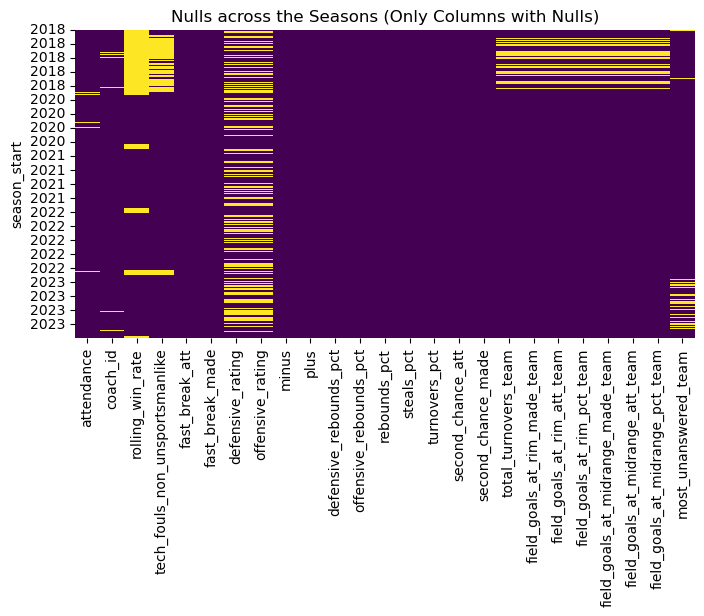

In [77]:
null_columns = df.columns[df.isnull().any()]
df_null = df[null_columns]

plt.figure(figsize=(8, 4))
sns.heatmap(df_null.isnull(), cbar=False, cmap='viridis')
plt.title('Nulls across the Seasons (Only Columns with Nulls)')
plt.show()



*RATIONALE*: in cases like rolling_win_rate, the raw fields that feed into this calculation may not have been stored in the past, and for certain types of matches like 'preseason' games. 

Like-wise for fields like field_goals_at_rim_made_team, etc. These fields may not have been collected or stored for some games and teams in the past. It seems like this problem disappears after 2018. 

I manually check some of these fields through the JSON output of the API calls on SportRadar and confirmed that some of these columns were indeed non-existent in the past (2018). For consistency - we will first drop these columns. Some of these fields are too specific anyways.

In [78]:
#example = df[df['field_goals_at_rim_made_team'].isnull()]['game_id'].values[0]
df = df.drop(columns=['rolling_win_rate','most_unanswered_team','tech_fouls_non_unsportsmanlike','field_goals_at_rim_made_team', 'field_goals_at_rim_att_team', 'field_goals_at_rim_pct_team', 'field_goals_at_midrange_made_team', 'field_goals_at_midrange_att_team', 'field_goals_at_midrange_pct_team', 'tech_fouls_non_unsportsmanlike', 'total_turnovers_team'])

#### Addressing Nulls in offensive/defensive ratings, coach_id, and attendance

I will now manually adjust check coach_id for data-entry issues, as their ID likely does exist and just needs to be mapped out

In [79]:
def get_id(name):
    return df[df['coach_name'].str.lower() == name.lower()]['coach_id'].unique()

# df[df['game_id'] == 'c45f61aa-8c12-4ecb-95cd-23cbf0e547b9'][['coach_name','coach_id']]
#get_id('Kevin Ollie')

#game_id: bb958f75-bb9f-458a-a2d0-5a9195af28ee, JB Bickerstaff should be 6b531f26-6942-4739-a3eb-518af5019c3f
#game_id : 39af541a-53bf-4add-8e49-9ea6c3b80664, James Borrego 35814a1b-b043-4d56-b6cf-022f1b967510
#game_id: 19ab17b3-14b8-4e23-aa6c-8e715298c833, JB again.
#game_id: 124038e7-beb7-4b10-a533-8bed1b02f56a, Ryan Saunders 0c9db4bc-580d-4e5c-8c0c-d573992ddb80
#game_id: ac8308b3-ab03-4cd2-9b89-afeaa47354ce' JB Bickerstaff
#game_id: 343a8c9d-93fb-4166-9a3f-b549758c4996, James Borrego
#game_id: 71a1d51e-5e20-455d-ad51-5dfcd96112cd, Joe Mazzulla  e301acea-babb-4d59-a3f9-dfe33ab8127d
#game_id: c45f61aa-8c12-4ecb-95cd-23cbf0e547b9, Kevin Ollie	 - Null , assign a '0' for this row as he doesn't have NBA coaching record

df.loc[(df['game_id'] == 'bb958f75-bb9f-458a-a2d0-5a9195af28ee') & (df['lakers'] == 0), 'coach_id'] = '6b531f26-6942-4739-a3eb-518af5019c3f'
df.loc[(df['game_id'] == '39af541a-53bf-4add-8e49-9ea6c3b80664') & (df['lakers'] == 0), 'coach_id'] = '35814a1b-b043-4d56-b6cf-022f1b967510'
df.loc[(df['game_id'] == '19ab17b3-14b8-4e23-aa6c-8e715298c833') & (df['lakers'] == 0), 'coach_id'] = '6b531f26-6942-4739-a3eb-518af5019c3f'
df.loc[(df['game_id'] == '124038e7-beb7-4b10-a533-8bed1b02f56a') & (df['lakers'] == 0), 'coach_id'] = '0c9db4bc-580d-4e5c-8c0c-d573992ddb80'
df.loc[(df['game_id'] == 'ac8308b3-ab03-4cd2-9b89-afeaa47354ce') & (df['lakers'] == 0), 'coach_id'] = '6b531f26-6942-4739-a3eb-518af5019c3f'
df.loc[(df['game_id'] == '343a8c9d-93fb-4166-9a3f-b549758c4996') & (df['lakers'] == 0), 'coach_id'] = '35814a1b-b043-4d56-b6cf-022f1b967510'
df.loc[(df['game_id'] == '71a1d51e-5e20-455d-ad51-5dfcd96112cd') & (df['lakers'] == 0), 'coach_id'] = 'e301acea-babb-4d59-a3f9-dfe33ab8127d'
df.loc[(df['game_id'] == 'c45f61aa-8c12-4ecb-95cd-23cbf0e547b9') & (df['lakers'] == 0), 'coach_id'] = '0'


The stadium was actually empty at the Cypto arena during March of 2021. These nulls should be converted to 0's for consistency with the rest of the field. 
 

The missing defensive and offensive rating missing values are due to players no playing in certain games. They should be converted to numeric (0's) for consistency

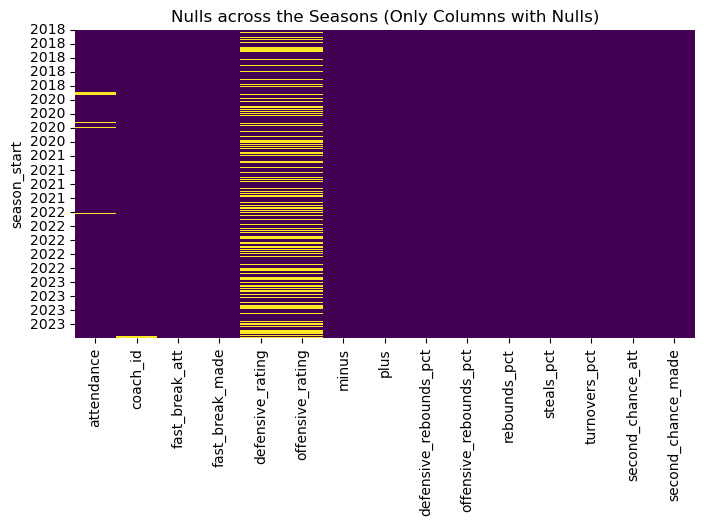

In [80]:
null_columns = df.columns[df.isnull().any()]
df_null = df[null_columns]

plt.figure(figsize=(8, 4))
sns.heatmap(df_null.isnull(), cbar=False, cmap='viridis')
plt.title('Nulls across the Seasons (Only Columns with Nulls)')
plt.show()


The missing coaches in 2024 we see is JJ redick. We can fill the reamining columns (see above) with nulls with 0

In [81]:
df.fillna(0, inplace=True)
df.isnull().sum().sort_values(ascending=False)

regular_szn                    0
defensive_rebounds_team        0
steals_team                    0
blocks_team                    0
assists_turnover_ratio_team    0
                              ..
efficiency_game_score          0
fouls_drawn                    0
offensive_fouls                0
points_in_paint                0
first_game_flag                0
Length: 148, dtype: int64

## More Data Exploration

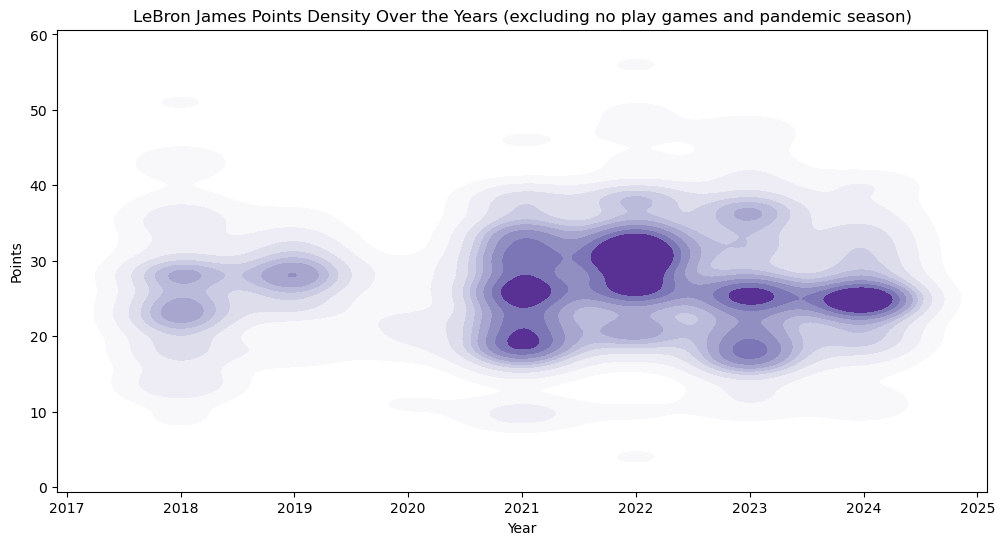

In [82]:
lebron_df = df[(df['name'] == 'LeBron James') & (df['playing'] == 1)]
lebron_df['game_dt'] = pd.to_datetime(lebron_df['game_dt'], errors='coerce')
lebron_df['Year'] = lebron_df['game_dt'].dt.year

plt.figure(figsize=(12, 6))
sns.kdeplot(x=lebron_df['Year'], y=lebron_df['points'], cmap="Purples", shade=True, bw_adjust=0.5)
plt.xlabel('Year')
plt.ylabel('Points')
plt.title("LeBron James Points Density Over the Years (excluding no play games and pandemic season)")
plt.grid(False)
 

plt.savefig('data_exploration/lebron_points_density.png')
plt.show()

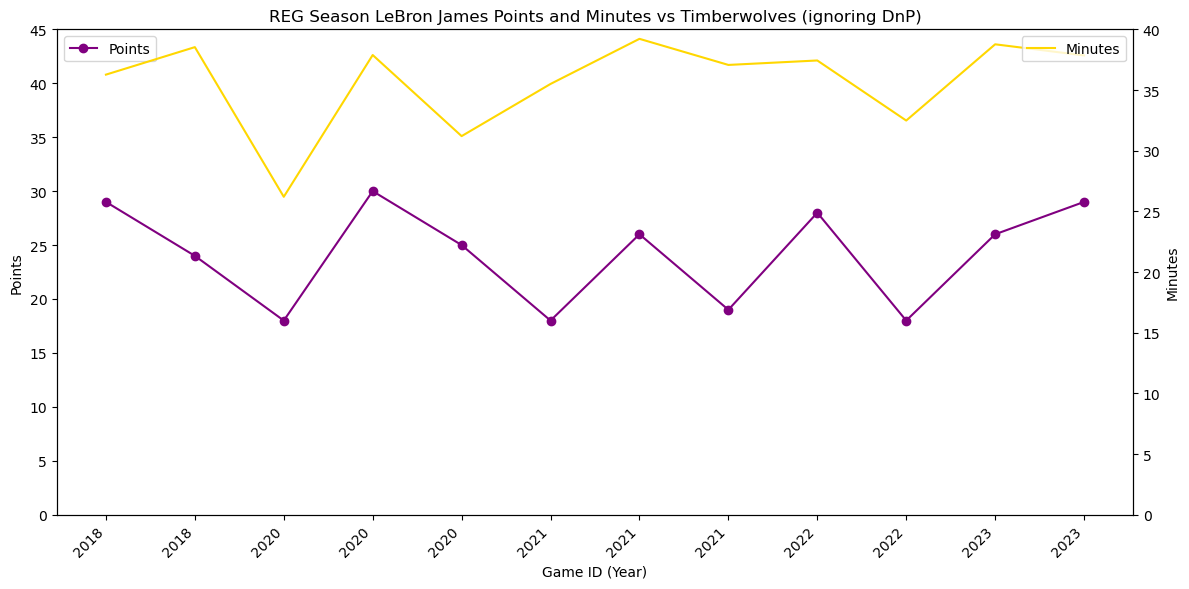

In [83]:
lebron_vs_wolves = df[(df['regular_szn'] == 1) & (df['name'] == 'LeBron James') & (df['wolves'] == 1) & (df['playing'] == 1)]


fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(lebron_vs_wolves['game_id'], lebron_vs_wolves['points'], color='purple', marker='o', label='Points')
ax1.set_xticks(range(len(lebron_vs_wolves)))
ax1.set_xticklabels(lebron_vs_wolves.index, rotation=45, ha='right')
ax1.set_xlabel('Game ID (Year)')
ax1.set_ylabel('Points')
ax1.set_ylim(0, 45)
ax1.set_title('REG Season LeBron James Points and Minutes vs Timberwolves (ignoring DnP)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(lebron_vs_wolves['game_id'], lebron_vs_wolves['minutes'], color='gold', label='Minutes')
ax2.set_ylabel('Minutes')
ax2.set_ylim(0, 40)
 
ax2.legend(loc='upper right')
plt.tight_layout()

plt.savefig('data_exploration/lebron_points_minutes.png')
plt.show()



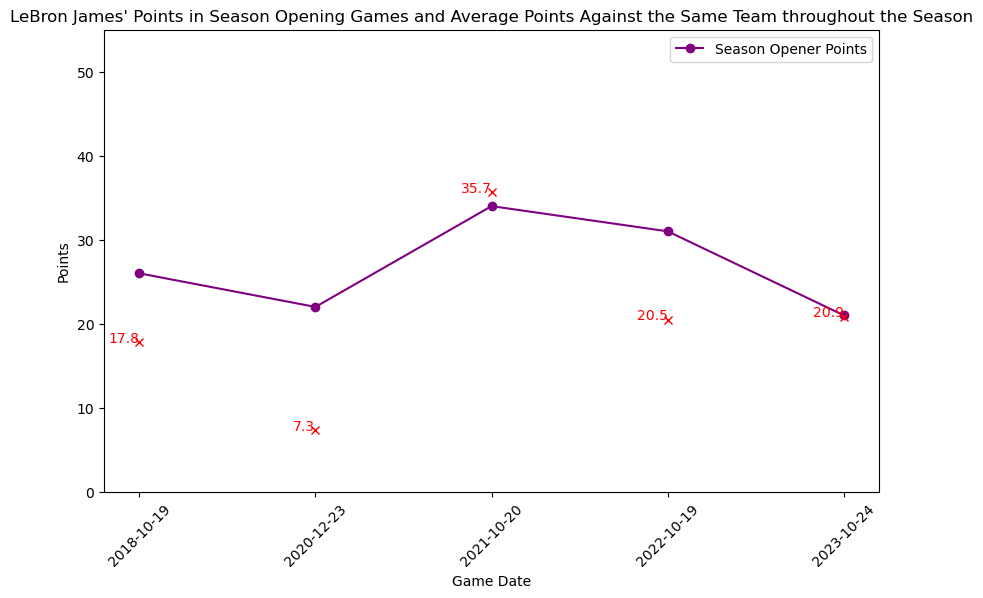

In [84]:
lebron_first_games = df[(df['regular_szn'] == 1) & (df['name'] == 'LeBron James') & (df['first_game_flag'] == 1)]
lebron_first_games['game_dt'] = pd.to_datetime(lebron_first_games['game_dt']).dt.strftime('%Y-%m-%d')
team_ids = lebron_first_games[['team_id_a']].drop_duplicates()


avg_points_against_teams = []
for _, row in lebron_first_games.iterrows():
    season = row.name  
    
    opponent_id = row['team_id_a']
    avg_points = df[(df['name'] == 'LeBron James') & (df.index == season) & (df['team_id_a'] == opponent_id)]['points'].mean()
    avg_points_against_teams.append(avg_points)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lebron_first_games['game_dt'], lebron_first_games['points'], marker='o', linestyle='-', color='purple', label="Season Opener Points")

for i, (game_date, avg_points) in enumerate(zip(lebron_first_games['game_dt'], avg_points_against_teams)):
    plt.plot(game_date, avg_points, marker='x', color='red')
    plt.text(game_date, avg_points, f'{avg_points:.1f}', color='red', ha='right' )

plt.xlabel('Game Date')
plt.ylabel('Points')
plt.title("LeBron James' Points in Season Opening Games and Average Points Against the Same Team throughout the Season")
plt.xticks(rotation=45)
plt.ylim(0, 55)
plt.grid(False)
plt.legend()

plt.savefig('data_exploration/lebron_points_season_openers.png')
plt.show()


In season opener games since 2018, LeBron has pretty consistently scored above his average against the same team throughout the rest of that season

# Feature Selection Process + Model Considerations


I had a couple visions for the objective of this assessment. I realized I was adding a lot of complexity in my head when thinking of all the possible factors that might impact the prediction

1. Linear Regression - this would be the easiest. I will test both Linear and Linear with Logistic Regression as a filter for no-play possibilities
   - I will transform the metrics to use rolling 3-5 game averages as inputs, too smooth out variability across games. For season openers, I will select Lebron's most recent games, including pre-season games.
 
2. Gradient Boosting (XGBoost) - my creative thought here was structuring my data to represent Lebron vs Player rows, where each row represent's LeBron's key offensive features joined with the opponent's key defensive features to capture player-to-player interactions. Features such as opponent position and whether they are currently on the wolves roster may be captured by XGboost ability to find complex/non-linear patterns. By transforming my data from 'game-to-game' to 'player-to-player for each game' rows, I am creating more granularity and can bring in more specific features and face less of a curse in dimensionality 
    - potential to overfit: I will run with cross validation grid-search to find optimal model hyperparams and play around with adjusting the model's complexity

3. Bayesian  (Kalman filter + exp Decay): Inspired by Kostya Medvedovsky, I wanted to see if I can implement similar logic in context to this prediction, seeing the availability of more recent data

In [85]:
#write df to base_data.csv
df.to_csv('data_exploration/base_data.csv', index=True)

In [86]:
pd.set_option('display.max_columns', None)

# Model - Regression (Linear + Logistic)

###  Rolling AVG as an Engineered Feature For Linear Regression
for lebron, his last 5 game rolling avg, for the opposing team - the last 5 total stat rolling avg AGAINST Lebron's team

In [87]:
def rolling_avg(df, player, stats, window=5):
    preseason_df = df[df['regular_szn'] == 0]
    
    for col in stats:

        df[f'{col}_avg_last_5'] = df.groupby(player)[col].rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)
        df[f'{col}_prev_game'] = df.groupby(player)[col].shift(1)

        opening_msk = (df['first_game_flag'] == 1) & (df['regular_szn'] == 1)
        first_games = df[opening_msk].index
        
        for game in first_games:
            player_id = df.at[game, player]
            game_date = df.at[game, 'game_dt']
            if game_date.year == 2024:
                print(f"game_dt: {game_date}")

            preseason_games = preseason_df[
                (preseason_df[player] == player_id) & 
                (preseason_df['game_dt'] < game_date) & 
                (preseason_df['playing'] == 1)
            ].sort_values('game_dt', ascending=False).head(window)
            
            if len(preseason_games) < window:
                last_season_games = df[
                    (df[player] == player_id) & 
                    (df['game_dt'] < game_date) & 
                    (df['playing'] == 1) &
                    (df['regular_szn'] == 1)
                ].sort_values('game_dt', ascending=False).head(window - len(preseason_games))
                
                combined_games = pd.concat([preseason_games, last_season_games]).sort_values('game_dt', ascending=False).head(window)
            else:
                combined_games = preseason_games
            
            combined_avg = combined_games[col].mean() if not combined_games.empty else df.at[game, col]
            df.at[game, f'{col}_avg_last_5'] = combined_avg
            df.at[game, f'{col}_prev_game'] = combined_games.iloc[0][col] if not combined_games.empty else df.at[game, col]
        
        df[f'{col}_avg_last_{window}'].fillna(df[col], inplace=True)
        df[f'{col}_prev_game'].fillna(df[col], inplace=True)

    return df


In [88]:
data = pd.read_csv('data_exploration/base_data.csv')

In [89]:
data.drop(columns=['team_id_h', 'team_id_a'], inplace=True)
data['game_dt'] = pd.to_datetime(data['game_dt'])

lebron_data = data[data['name'] == 'LeBron James']
opponent_data = data[(data['name'] != 'LeBron James') & (data['lakers'] == 0)]

label = lebron_data[['game_id', 'points']].copy()  

categorical_columns = ['home','position', 'current_wolves', 'wolves', 'first_game_flag', 'attendance',  'game_officials_exp', 
                       'regular_szn', 'game_dt', 'game_id', 'player_id',  'name', 'time_zone', 'coach_id', 
                       'coach_name', 'most_unanswered_team']

lebron_stats = [col for col in data.columns if col not in categorical_columns and 'team' not in col]
opponent_stats = [col for col in data.columns if col not in categorical_columns and 'team' not in col]

# Apply rolling average functions
lebron_data = rolling_avg(lebron_data, player='player_id', stats=lebron_stats, window=5)
lebron_data.rename(columns={f'{col}_avg_last_5': f'{col}_lebron_avg_last_5' for col in lebron_stats}, inplace=True)
lebron_data.rename(columns={f'{col}_prev_game' : f'{col}_lebron_prev_game' for col in lebron_stats},  inplace=True)
lebron_data = lebron_data[[col for col in lebron_data.columns if col in categorical_columns or col.endswith('_lebron_avg_last_5')]]

opponent_data = rolling_avg(opponent_data, player='player_id', stats=opponent_stats, window=5)
opponent_data.rename(columns={f'{col}_avg_last_5': f'{col}_opponent_avg_last_5' for col in opponent_stats}, inplace=True)
opponent_data = opponent_data[[col for col in opponent_data.columns if col in categorical_columns or col.endswith('_team_opponent_avg_last_5')]]

processed_data = lebron_data.merge(
    opponent_data,
    on=['game_id', 'game_dt', 'regular_szn', 'wolves', 'attendance', 'game_officials_exp', 'first_game_flag'],  
    how='left',
    suffixes=('_lebron', '_opponent')
)
processed_data.drop(columns=['current_wolves_lebron','lakers_lebron_avg_last_5'], inplace=True)
processed_data = processed_data.merge(label, on='game_id', how='left')
processed_data.head()

,regular_szn,game_dt,game_id,game_officials_exp,player_id_lebron,name_lebron,position_lebron,wolves,home_lebron,time_zone_lebron,attendance,coach_id_lebron,coach_name_lebron,first_game_flag,season_start_lebron_avg_last_5,playing_lebron_avg_last_5,minutes_lebron_avg_last_5,field_goals_made_lebron_avg_last_5,field_goals_att_lebron_avg_last_5,field_goals_pct_lebron_avg_last_5,three_points_made_lebron_avg_last_5,three_points_att_lebron_avg_last_5,three_points_pct_lebron_avg_last_5,two_points_made_lebron_avg_last_5,two_points_att_lebron_avg_last_5,two_points_pct_lebron_avg_last_5,blocked_att_lebron_avg_last_5,free_throws_made_lebron_avg_last_5,free_throws_att_lebron_avg_last_5,free_throws_pct_lebron_avg_last_5,offensive_rebounds_lebron_avg_last_5,defensive_rebounds_lebron_avg_last_5,rebounds_lebron_avg_last_5,assists_lebron_avg_last_5,turnovers_lebron_avg_last_5,steals_lebron_avg_last_5,blocks_lebron_avg_last_5,assists_turnover_ratio_lebron_avg_last_5,personal_fouls_lebron_avg_last_5,tech_fouls_lebron_avg_last_5,flagrant_fouls_lebron_avg_last_5,pls_min_lebron_avg_last_5,points_lebron_avg_last_5,double_double_lebron_avg_last_5,triple_double_lebron_avg_last_5,effective_fg_pct_lebron_avg_last_5,efficiency_lebron_avg_last_5,efficiency_game_score_lebron_avg_last_5,fouls_drawn_lebron_avg_last_5,offensive_fouls_lebron_avg_last_5,points_in_paint_lebron_avg_last_5,points_in_paint_att_lebron_avg_last_5,points_in_paint_made_lebron_avg_last_5,points_in_paint_pct_lebron_avg_last_5,points_off_turnovers_lebron_avg_last_5,true_shooting_att_lebron_avg_last_5,true_shooting_pct_lebron_avg_last_5,coach_ejections_lebron_avg_last_5,coach_tech_fouls_lebron_avg_last_5,second_chance_pts_lebron_avg_last_5,second_chance_pct_lebron_avg_last_5,fast_break_pts_lebron_avg_last_5,fast_break_att_lebron_avg_last_5,fast_break_made_lebron_avg_last_5,fast_break_pct_lebron_avg_last_5,defensive_rating_lebron_avg_last_5,offensive_rating_lebron_avg_last_5,minus_lebron_avg_last_5,plus_lebron_avg_last_5,defensive_rebounds_pct_lebron_avg_last_5,offensive_rebounds_pct_lebron_avg_last_5,rebounds_pct_lebron_avg_last_5,steals_pct_lebron_avg_last_5,turnovers_pct_lebron_avg_last_5,second_chance_att_lebron_avg_last_5,second_chance_made_lebron_avg_last_5,player_id_opponent,name_opponent,position_opponent,current_wolves_opponent,home_opponent,time_zone_opponent,coach_id_opponent,coach_name_opponent,points
0,0,2018-10-01 01:30:00,50d9471c-92cd-4a2c-a152-96c5b8106246,2,0afbe608-940a-4d5d-a1f7-468718c67d91,LeBron James,F,0,1,US/Pacific,13565.0,1352daff-91ea-49d2-83c6-45fedaf0402a,Luke Walton,0,2018.0,1.0,15.316667,2.0,6.0,33.3,2.0,2.0,100.0,0.0,4.0,0.0,0.0,3.0,4.0,75.0,0.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,9.0,0.0,0.0,50.0,9.0,6.4,2.0,0.0,0.0,1.0,0.0,0.0,0.0,7.76,58.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,0.0,116.29482,113.897794,42.0,43.0,21.841905,0.0,10.795424,0.0,11.415525,1.0,1.0,0d5fda49-9c91-4224-8dba-338716d0a954,Xavier Silas,G,0,0,US/Mountain,9b3f6de7-52d7-4aa7-b76a-ee78dd3c0d30,Michael Malone,9
1,0,2018-10-01 01:30:00,50d9471c-92cd-4a2c-a152-96c5b8106246,2,0afbe608-940a-4d5d-a1f7-468718c67d91,LeBron James,F,0,1,US/Pacific,13565.0,1352daff-91ea-49d2-83c6-45fedaf0402a,Luke Walton,0,2018.0,1.0,15.316667,2.0,6.0,33.3,2.0,2.0,100.0,0.0,4.0,0.0,0.0,3.0,4.0,75.0,0.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,9.0,0.0,0.0,50.0,9.0,6.4,2.0,0.0,0.0,1.0,0.0,0.0,0.0,7.76,58.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,0.0,116.29482,113.897794,42.0,43.0,21.841905,0.0,10.795424,0.0,11.415525,1.0,1.0,f9b41748-5ab8-4ff7-9fc8-ecfec9f12d4b,Tyler Lydon,F,0,0,US/Mountain,9b3f6de7-52d7-4aa7-b76a-ee78dd3c0d30,Michael Malone,9
2,0,2018-10-01 01:30:00,50d9471c-92cd-4a2c-a152-96c5b8106246,2,0afbe608-940a-4d5d-a1f7-468718c67d91,LeBron James,F,0,1,US/Pacific,13565.0,1352daff-91ea-49d2-83c6-45fedaf0402a,Luke Walton,0,2018.0,1.0,15.316667,2.0,6.0,33.3,2.0,2.0,100.0,0.0,4.0,0.0,0.0,3.0,4.0,75.0,0.0,3.0,3.0,3.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,9.0,0.0,0.0,50.0,9.0,6.4,2.0,0.0,0.0,1.0,0.0,0.0,0.0,7.76,58.0,0.0,0.0,3.0,10

In [90]:
processed_data=processed_data.drop_duplicates(subset='game_id', keep='first')

lin_reg = processed_data[processed_data['game_dt'].dt.year != 2024]

In [91]:
lin_reg = processed_data.drop(
    [col for col in processed_data.columns 
     if (col.endswith('_team_lebron_avg_last_5') or col.endswith('_opponent_avg_last_5') or col.endswith('_opponent')) 
     and not col.endswith('_team_opponent_avg_last_5')],
    axis=1
)
lin_reg_2024 = lin_reg[(processed_data['game_dt'].dt.year == 2024) & (processed_data['regular_szn']==0)]#saving this for prediction later
lin_reg.drop(columns=['regular_szn','game_id','game_dt', 'player_id_lebron', 'name_lebron','position_lebron', 'time_zone_lebron', 'coach_id_lebron', 'coach_name_lebron','season_start_lebron_avg_last_5'], inplace=True)
lin_reg = lin_reg.loc[:, (lin_reg != 0).any(axis=0)]
lin_reg = lin_reg.dropna()

Still a whole lot of features to narrow down. Running a correlation matrix

In [92]:
corr_matrix = lin_reg.corr()

# Ignore self-correlation  
np.fill_diagonal(corr_matrix.values, np.nan)

#plt.figure(figsize=(12, 10))
#sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
#plt.title('Correlation Matrix')
#plt.show()

pos_corr = corr_matrix['points'].sort_values(ascending=False).head(10)
neg_corr = corr_matrix['points'].dropna().sort_values(ascending=False).tail(10)
print ("Positive Correlation")
print (pos_corr)
print ("\nNegative Correlation")
print (neg_corr)

Positive Correlation
points_lebron_avg_last_5                   0.704112
true_shooting_att_lebron_avg_last_5        0.692891
plus_lebron_avg_last_5                     0.692851
efficiency_lebron_avg_last_5               0.692281
field_goals_made_lebron_avg_last_5         0.692185
efficiency_game_score_lebron_avg_last_5    0.691161
minutes_lebron_avg_last_5                  0.689016
minus_lebron_avg_last_5                    0.687070
field_goals_att_lebron_avg_last_5          0.685428
two_points_pct_lebron_avg_last_5           0.683157
Name: points, dtype: float64

Negative Correlation
offensive_fouls_lebron_avg_last_5    0.367650
triple_double_lebron_avg_last_5      0.224458
attendance                           0.124101
tech_fouls_lebron_avg_last_5         0.121425
pls_min_lebron_avg_last_5            0.114115
first_game_flag                      0.063485
flagrant_fouls_lebron_avg_last_5     0.042466
home_lebron                          0.027845
game_officials_exp                   0.0

Looking at the top features correlated to LeBron's points, are unsuprisingly inputs very much tied to points-Lebron's rolling avg for points, true shooting, field goals made are all components to points. I want a subset of this list that doesn't intersect with each other, and for that I will be seeing what the highest correlated pairs are

In [93]:
top_features = list(pos_corr.index) + list(neg_corr.index)
top_corr_matrix = corr_matrix.loc[top_features, top_features]


top_corr_pairs = top_corr_matrix.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()
top_corr_pairs = top_corr_pairs[top_corr_pairs < 1] 

top_corr_pairs.head(10)



field_goals_att_lebron_avg_last_5        true_shooting_att_lebron_avg_last_5        0.997633
efficiency_lebron_avg_last_5             efficiency_game_score_lebron_avg_last_5    0.995423
field_goals_made_lebron_avg_last_5       points_lebron_avg_last_5                   0.993458
plus_lebron_avg_last_5                   minutes_lebron_avg_last_5                  0.989802
minus_lebron_avg_last_5                  minutes_lebron_avg_last_5                  0.988776
                                         plus_lebron_avg_last_5                     0.986991
points_lebron_avg_last_5                 true_shooting_att_lebron_avg_last_5        0.984356
true_shooting_att_lebron_avg_last_5      field_goals_made_lebron_avg_last_5         0.983668
efficiency_game_score_lebron_avg_last_5  points_lebron_avg_last_5                   0.983631
field_goals_made_lebron_avg_last_5       field_goals_att_lebron_avg_last_5          0.983529
dtype: float64

Features I Chose from the pairings + Rationale:

- true_shooting_att_lebron_avg_last_5: this metric includes fga but also free throw attempts
- efficiency_lebron_avg_last_5: similar to the other pair, but has higher corr with points.
- points_lebron_avg_last_5: more directly tied and relavent to our prediction
- playing_lebron_avg_last_5: really significant to points, past avg could point to no play (e.g. explained by injury)
- minutes_lebron_avg_last_5: +/- compares lebron impact to the team performance, Daymond has high +/- but low points.
- points_in_paint_pct_lebron_avg_last_5 - vs certain teams that have dominant centers and defenders
- offensive_rating_lebron_avg_last_5 - includes efficiency

 i want features with high predictive power towards points while being independent. I will remove the features most uncorrelated to points, then run PCA to see if we reduce multicollinearity by reducing dimension into lower # of features that capture the variance

In [94]:

correlation_threshold = 0.1

abs_corr = corr_matrix['points'].abs()
filtered_features = abs_corr[abs_corr >= correlation_threshold].index

lin_reg_filtered = lin_reg[filtered_features]
lin_reg_filtered.head()

,attendance,playing_lebron_avg_last_5,minutes_lebron_avg_last_5,field_goals_made_lebron_avg_last_5,field_goals_att_lebron_avg_last_5,field_goals_pct_lebron_avg_last_5,three_points_made_lebron_avg_last_5,three_points_att_lebron_avg_last_5,three_points_pct_lebron_avg_last_5,two_points_made_lebron_avg_last_5,two_points_att_lebron_avg_last_5,two_points_pct_lebron_avg_last_5,blocked_att_lebron_avg_last_5,free_throws_made_lebron_avg_last_5,free_throws_att_lebron_avg_last_5,free_throws_pct_lebron_avg_last_5,offensive_rebounds_lebron_avg_last_5,defensive_rebounds_lebron_avg_last_5,rebounds_lebron_avg_last_5,assists_lebron_avg_last_5,turnovers_lebron_avg_last_5,steals_lebron_avg_last_5,blocks_lebron_avg_last_5,assists_turnover_ratio_lebron_avg_last_5,personal_fouls_lebron_avg_last_5,tech_fouls_lebron_avg_last_5,pls_min_lebron_avg_last_5,points_lebron_avg_last_5,double_double_lebron_avg_last_5,triple_double_lebron_avg_last_5,effective_fg_pct_lebron_avg_last_5,efficiency_lebron_avg_last_5,efficiency_game_score_lebron_avg_last_5,fouls_drawn_lebron_avg_last_5,offensive_fouls_lebron_avg_last_5,points_in_paint_lebron_avg_last_5,points_in_paint_att_lebron_avg_last_5,points_in_paint_made_lebron_avg_last_5,points_in_paint_pct_lebron_avg_last_5,points_off_turnovers_lebron_avg_last_5,true_shooting_att_lebron_avg_last_5,true_shooting_pct_lebron_avg_last_5,second_chance_pts_lebron_avg_last_5,second_chance_pct_lebron_avg_last_5,fast_break_pts_lebron_avg_last_5,fast_break_att_lebron_avg_last_5,fast_break_made_lebron_avg_last_5,fast_break_pct_lebron_avg_last_5,defensive_rating_lebron_avg_last_5,offensive_rating_lebron_avg_last_5,minus_lebron_avg_last_5,plus_lebron_avg_last_5,defensive_rebounds_pct_lebron_avg_last_5,offensive_rebounds_pct_lebron_avg_last_5,rebounds_pct_lebron_avg_last_5,steals_pct_lebron_avg_last_5,turnovers_pct_lebron_avg_last_5,second_chance_att_lebron_avg_last_5,second_chance_made_lebron_avg_last_5
0,13565.0,1.00,15.316667,2.000000,6.000000,33.300000,2.00,2.000000,100.000000,0.000000,4.0,0.000,0.0,3.000000,4.000000,75.000000,0.0,3.00,3.00,3.000000,1.000000,0.000000,0.000000,3.000000,2.000000,0.0,1.0,9.000000,0.0,0.0,50.000000,9.000000,6.40,2.000000,0.000000,0.0,1.000000,0.00,0.0,0.000000,7.760,58.000000,3.0,100.000000,0.000000,0.0,0.000000,0.000000,116.294820,113.897794,42.000000,43.000000,21.841905,0.0,10.795424,0.000000,11.415525,1.000000,1.000000
20,18997.0,1.00,14.983333,3.500000,6.000000,58.300000,1.50,1.500000,100.000000,2.000000,4.5,40.000,0.0,2.500000,3.500000,70.850000,0.0,3.00,3.00,3.000000,2.500000,1.000000,0.500000,1.875000,1.000000,0.0,7.0,11.000000,0.0,0.0,70.850000,13.500000,9.25,2.000000,0.000000,3.0,2.500000,1.50,37.5,2.500000,7.540,73.400000,1.5,50.000000,3.500000,1.5,1.500000,50.000000,103.708026,111.417022,36.000000,43.000000,21.377709,0.0,11.698578,2.937994,23.375607,0.500000,0.500000
40,18997.0,1.00,15.200000,4.333333,7.333333,58.866667,1.00,1.333333,66.666667,3.333333,6.0,48.900,0.0,3.666667,4.333333,80.566667,0.0,3.00,3.00,3.333333,2.666667,0.666667,0.333333,1.693333,1.333333,0.0,4.0,13.333333,0.0,0.0,67.233333,15.666667,10.60,2.666667,0.333333,6.0,4.333333,3.00,50.0,2.333333,9.240,72.666667,2.0,66.666667,3.666667,2.0,1.666667,55.566667,105.324766,115.689050,39.333333,43.333333,20.392531,0.0,11.248898,1.958662,21.977600,0.666667,0.666667
59,18040.0,0.75,11.400000,3.250000,5.500000,44.150000,0.75,1.000000,50.000000,2.500000,4.5,36.675,0.0,2.750000,3.250000,60.425000,0.0,2.25,2.25,2.500000,2.000000,0.500000,0.250000,1.270000,1.000000,0.0,3.0,10.000000,0.0,0.0,50.425000,11.750000,7.95,2.000000,0.250000,4.5,3.250000,2.25,37.5,1.750000,6.930,54.500000,1.5,50.000000,2.750000,1.5,1.250000,41.675000,78.993574,86.766788,29.500000,32.500000,15.294398,0.0,8.436673,1.468997,16.483200,0.500000,0.500000
79,1763.0,0.80,12.643333,3.600000,6.000000,47.820000,0.80,1.200000,50.000000,2.800000,4.8,42.680,0.0,3.000000,3.600000,64.340000,0.0,3.80,3.80,3.000000,1.800000,0.600000,0.200000,2.016000,0.800000,0.0,3.2,11.000000,0.2,0.0,

In [95]:
X = lin_reg.drop(columns=['points'])
y = lin_reg['points']

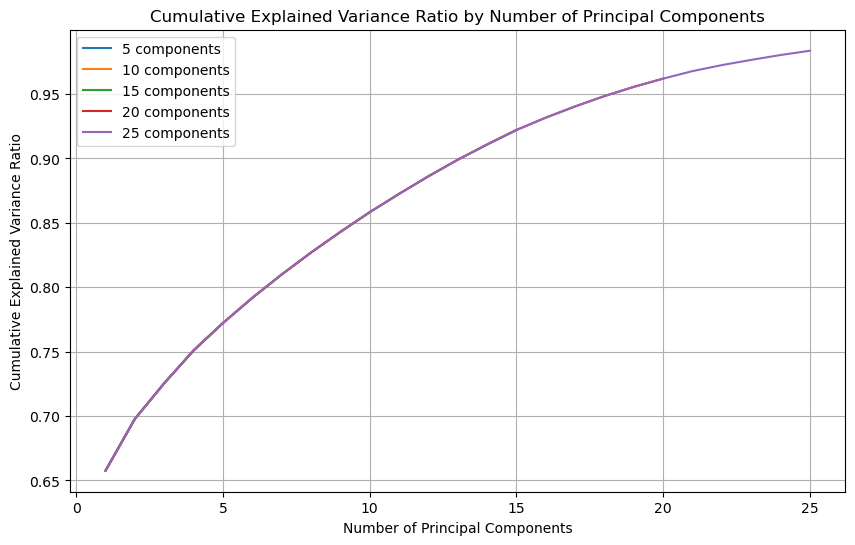

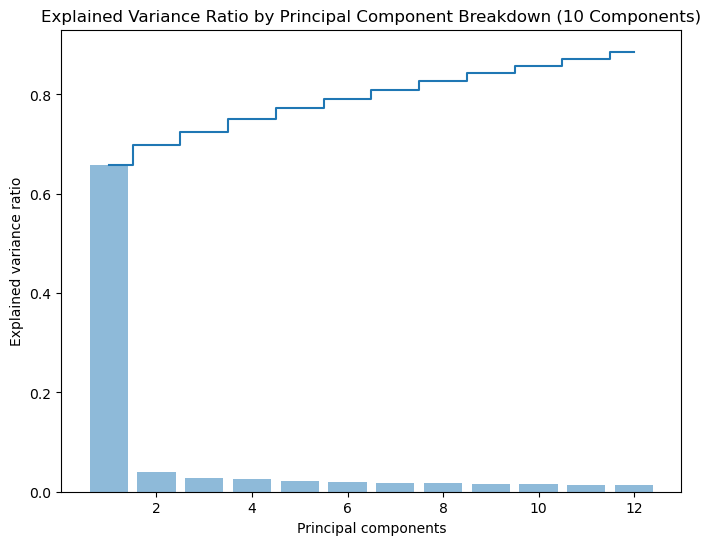

In [96]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# for visualization
components = [5, 10, 15, 20, 25]
explained_variances = []

for n in components:
    pca = PCA(n_components=n)
    pca.fit(X_scaled)
    explained_variances.append(pca.explained_variance_ratio_.cumsum())

plt.figure(figsize=(10, 6))
for i, n in enumerate(components):
    plt.plot(range(1, n + 1), explained_variances[i], label=f'{n} components')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.legend()
plt.grid(True)
plt.show()


pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance Ratio by Principal Component Breakdown (10 Components)')
plt.show()


In [97]:

with open('lin_reg_feat.txt', 'w') as f:
    for col in X.columns:
        f.write(f"{col}\n")

R2 Score: 0.4499582013271666
Mean Squared Error: 88.96427813374736


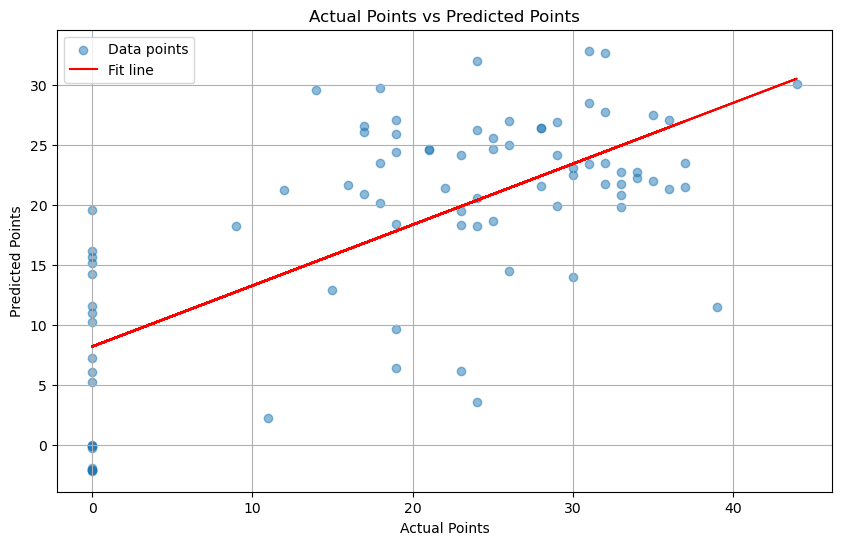

Game with highest error:
Actual Points: 39
Predicted Points: 11.430249247863648


In [98]:
features = X.columns
target = 'points'
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=15)),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Data points')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual Points vs Predicted Points')

# Fit line
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color='red', label='Fit line')

plt.legend()
plt.grid(True)
plt.show()

# Add more error analysis
residuals = np.abs(y_test - y_pred)
max_error_idx = np.argmax(residuals)
print(f"Game with highest error:\nActual Points: {y_test.iloc[max_error_idx]}\nPredicted Points: {y_pred[max_error_idx]}")





My linear model struggles to predict games where LeBron did not play. Some cases when LeBron does not play aren't explained by linear scoring metrics we inputed. 

### Model Iteration w/ Grid Search + Implementation of Logistic Regression as filter
adding two step model where logistic regression classified whether LeBron will play first, and combining with linear model. Testing optimal params for both. 

In [99]:
#adding prediction for 2024 (so i can directly plug into model)
expected_features = [
    'minutes', 'field_goals_made', 'field_goals_att', 'field_goals_pct', 'three_points_made', 'three_points_att',
    'three_points_pct', 'two_points_made', 'two_points_att', 'two_points_pct', 'blocked_att', 'free_throws_made',
    'free_throws_att', 'free_throws_pct', 'offensive_rebounds', 'defensive_rebounds', 'rebounds', 'assists',
    'turnovers', 'steals', 'blocks', 'assists_turnover_ratio', 'personal_fouls', 'tech_fouls', 'flagrant_fouls',
    'pls_min', 'points', 'double_double', 'triple_double', 'effective_fg_pct', 'efficiency', 'efficiency_game_score',
    'fouls_drawn', 'offensive_fouls', 'points_in_paint', 'points_in_paint_att', 'points_in_paint_made',
    'points_in_paint_pct', 'points_off_turnovers', 'true_shooting_att', 'true_shooting_pct', 'second_chance_pts',
    'second_chance_pct', 'fast_break_pts', 'fast_break_att', 'fast_break_made', 'fast_break_pct', 'defensive_rating',
    'offensive_rating', 'minus', 'plus', 'defensive_rebounds_pct', 'offensive_rebounds_pct', 'rebounds_pct',
    'steals_pct', 'turnovers_pct', 'second_chance_att', 'second_chance_made'
]

lebron_df = df[df['name'] == 'LeBron James']
lebron_df['game_dt'] = pd.to_datetime(lebron_df['game_dt'])

target_date = datetime(2024, 10, 22)
lebron_df_before = lebron_df[lebron_df['game_dt'] < target_date]
lebron_df_before = lebron_df_before.sort_values('game_dt', ascending=False)
last_5_games = lebron_df_before.head(5)
rolling_avg = last_5_games[expected_features].mean()
prediction_input = rolling_avg.to_frame().T
prediction_input.columns = [f'{col}_lebron_avg_last_5' for col in prediction_input.columns]

# context features
prediction_input['game_officials_exp'] =  12  
prediction_input['wolves'] = 1  
prediction_input['home_lebron'] = 1 
prediction_input['attendance'] = 19000  
prediction_input['first_game_flag'] = 1 
prediction_input['playing_lebron_avg_last_5'] = 1 

In [100]:

features = X.columns
target = 'points'
prediction_input = prediction_input[features]

X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.2, random_state=42)

# binary split - above or below point median
y_train_binary = (y_train > y_train.median()).astype(int)
y_test_binary = (y_test > y_test.median()).astype(int)


logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('classifier', LogisticRegression())
])
logistic_param_grid = {
    'pca__n_components': [5, 10, 15],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

logistic_grid_search = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
logistic_grid_search.fit(X_train, y_train_binary)

print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Best cross-validation score for Logistic Regression:", logistic_grid_search.best_score_)

lebron_logistic = logistic_grid_search.best_estimator_

# Step 2: Linear Regression (two separate models for above and below median)
# Above median
X_train_above = X_train[y_train > y_train.median()]
y_train_above = y_train[y_train > y_train.median()]

linear_pipeline_above = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('regressor', LinearRegression())
])

linear_param_grid = {
    'pca__n_components': [5, 10, 15],
}

linear_grid_search_above = GridSearchCV(linear_pipeline_above, linear_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
linear_grid_search_above.fit(X_train_above, y_train_above)

print("Best parameters for Linear Regression (Above Median):", linear_grid_search_above.best_params_)
print("Best cross-validation score for Linear Regression (Above Median):", -linear_grid_search_above.best_score_)

lebron_linear_above = linear_grid_search_above.best_estimator_

# Below median
X_train_below = X_train[y_train <= y_train.median()]
y_train_below = y_train[y_train <= y_train.median()]

linear_grid_search_below = GridSearchCV(linear_pipeline_above, linear_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
linear_grid_search_below.fit(X_train_below, y_train_below)

print("Best parameters for Linear Regression (Below Median):", linear_grid_search_below.best_params_)
print("Best cross-validation score for Linear Regression (Below Median):", -linear_grid_search_below.best_score_)

lebron_linear_below = linear_grid_search_below.best_estimator_


# Step 1: Logistic Regression
y_pred_logistic = lebron_logistic.predict(X_test)
accuracy_logistic = accuracy_score(y_test_binary, y_pred_logistic)
print(f"Logistic Regression Accuracy: {accuracy_logistic}")

# Step 2: Linear Regression
y_pred_linear = np.where(
    y_pred_logistic == 1,
    lebron_linear_above.predict(X_test),
    lebron_linear_below.predict(X_test)
)

mse_two_step = mean_squared_error(y_test, y_pred_linear)
r2_two_step = r2_score(y_test, y_pred_linear)
print(f"Two-Step Regression MSE: {mse_two_step}")
print(f"Two-Step Regression R2 Score: {r2_two_step}")

# 2 step feed
def predict_points_two_step(X_new):
    above_median_pred = lebron_logistic.predict(X_new)
    
    points_pred = np.where(
        above_median_pred == 1,
        lebron_linear_above.predict(X_new),
        lebron_linear_below.predict(X_new)
    )
    
    return points_pred
predicted_points = predict_points_two_step(X_test)

#test on prediction_input
predicted_points_2024 = predict_points_two_step(prediction_input)


logistic_coef = lebron_logistic.named_steps['classifier'].coef_[0]
pca_components = lebron_logistic.named_steps['pca'].components_
logistic_feature_importance = np.abs(np.dot(pca_components.T, logistic_coef))
logistic_feature_importance = pd.Series(logistic_feature_importance, index=features).sort_values(ascending=False)
print("Top features for Logistic Regression:")
print(logistic_feature_importance.head(5))


linear_coef_above = lebron_linear_above.named_steps['regressor'].coef_
pca_components_above = lebron_linear_above.named_steps['pca'].components_
linear_feature_importance_above = np.abs(np.dot(pca_components_above.T, linear_coef_above))
linear_feature_importance_above = pd.Series(linear_feature_importance_above, index=features).sort_values(ascending=False)
print("\nTop features for Linear Regression (Above Median):")
print(linear_feature_importance_above.head(5))


linear_coef_below = lebron_linear_below.named_steps['regressor'].coef_
pca_components_below = lebron_linear_below.named_steps['pca'].components_
linear_feature_importance_below = np.abs(np.dot(pca_components_below.T, linear_coef_below))
linear_feature_importance_below = pd.Series(linear_feature_importance_below, index=features).sort_values(ascending=False)
print("\nTop features for Linear Regression (Below Median):")
print(linear_feature_importance_below.head(5))


Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'pca__n_components': 5}
Best cross-validation score for Logistic Regression: 0.738533674339301
Best parameters for Linear Regression (Above Median): {'pca__n_components': 15}
Best cross-validation score for Linear Regression (Above Median): 33.0066001561587
Best parameters for Linear Regression (Below Median): {'pca__n_components': 10}
Best cross-validation score for Linear Regression (Below Median): 49.7764106274965
Logistic Regression Accuracy: 0.7209302325581395
Two-Step Regression MSE: 95.14645994710551
Two-Step Regression R2 Score: 0.4117354620921019
Top features for Logistic Regression:
second_chance_att_lebron_avg_last_5         0.044585
offensive_rebounds_lebron_avg_last_5        0.044375
second_chance_made_lebron_avg_last_5        0.041076
second_chance_pts_lebron_avg_last_5         0.040672
offensive_rebounds_pct_lebron_avg_last_5    0.040143
dtype: 

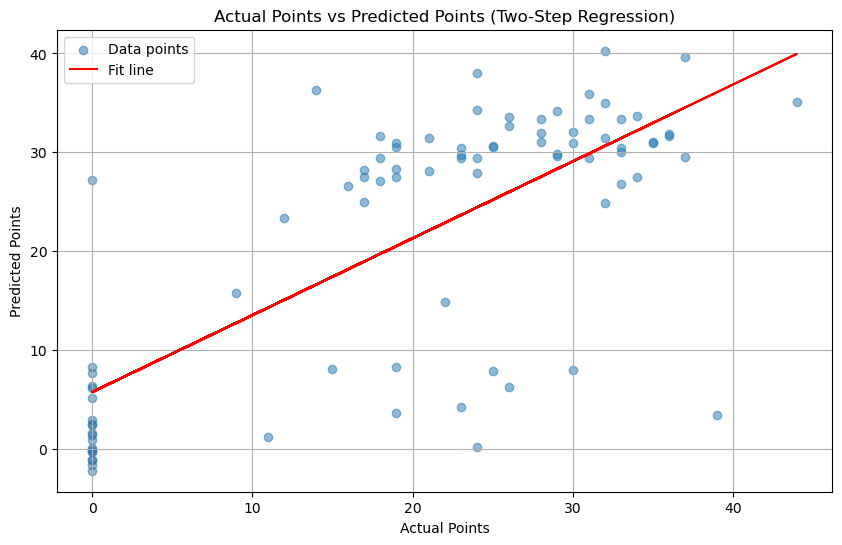

In [101]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_points, alpha=0.5, label='Data points')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual Points vs Predicted Points (Two-Step Regression)')
plt.legend()
plt.grid(True)

# Fit line of best fit
m, b = np.polyfit(y_test, predicted_points, 1)
plt.plot(y_test, m * y_test + b, color='red', label='Fit line')

plt.legend()
plt.show()


In [102]:

# Step 1: Logistic Regression
y_pred_logistic = lebron_logistic.predict(X_test)
accuracy_logistic = accuracy_score(y_test_binary, y_pred_logistic)
print(f"Logistic Regression Accuracy: {accuracy_logistic}")
print(classification_report(y_test_binary, y_pred_logistic))

Logistic Regression Accuracy: 0.7209302325581395
              precision    recall  f1-score   support

           0       0.84      0.58      0.68        45
           1       0.65      0.88      0.75        41

    accuracy                           0.72        86
   macro avg       0.75      0.73      0.72        86
weighted avg       0.75      0.72      0.72        86



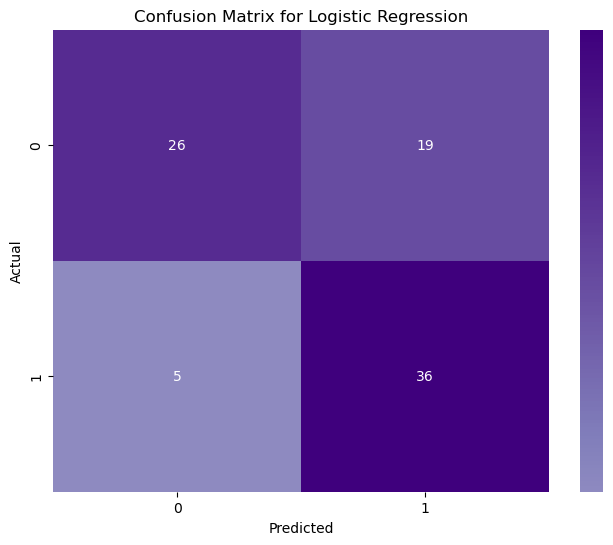

In [103]:
cm = confusion_matrix(y_test_binary, y_pred_logistic)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', center=0, cbar_kws={'ticks': [0, 1]})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


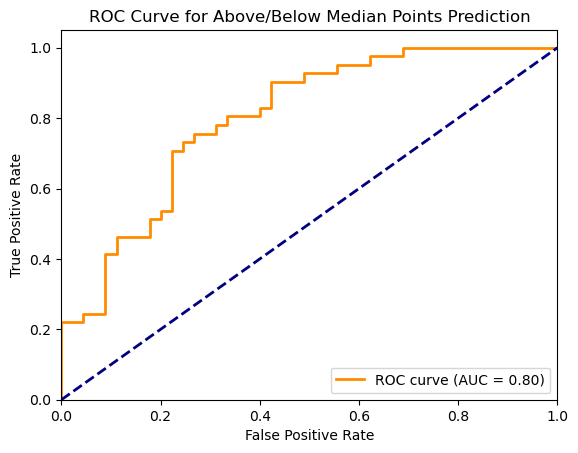

AUC-ROC Score: 0.8005420054200543


In [104]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = lebron_logistic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Above/Below Median Points Prediction')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC Score: {roc_auc}")

# Model 1 Prediction: Using 2 Step Version

In [105]:
print(f"LeBron James Points on Opening Day: {predicted_points_2024}")


LeBron James Points on Opening Day: [26.22031081]


# Model 2: XGBoost 

In [106]:
df = pd.read_csv('data_exploration/base_data.csv')

In [107]:
lebron_opponent_matchups = []

for game_id in df['game_id'].unique():
    game_data = df[df['game_id'] == game_id]
    lebron_data = game_data[game_data['name'] == 'LeBron James']
    opponent_data = game_data[game_data['lakers'] == 0]
    
    for _, lebron_row in lebron_data.iterrows():
        for _, opponent_row in opponent_data.iterrows():
            matchup = lebron_row.to_dict()
            for col in opponent_row.index:
                matchup[f'opponent_{col}'] = opponent_row[col]
            lebron_opponent_matchups.append(matchup)

matchup_df = pd.DataFrame(lebron_opponent_matchups)
matchup_df.head()

,season_start,regular_szn,game_dt,game_id,game_officials_exp,player_id,name,position,team_id_h,team_id_a,lakers,wolves,current_wolves,home,time_zone,attendance,coach_id,coach_name,playing,minutes,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,tech_fouls,flagrant_fouls,pls_min,points,double_double,triple_double,effective_fg_pct,efficiency,efficiency_game_score,fouls_drawn,offensive_fouls,points_in_paint,points_in_paint_att,points_in_paint_made,points_in_paint_pct,points_off_turnovers,true_shooting_att,true_shooting_pct,coach_ejections,coach_tech_fouls,second_chance_pts,second_chance_pct,fast_break_pts,fast_break_att,fast_break_made,fast_break_pct,defensive_rating,offensive_rating,minus,plus,defensive_rebounds_pct,offensive_rebounds_pct,rebounds_pct,steals_pct,turnovers_pct,second_chance_att,second_chance_made,minutes_team,field_goals_made_team,field_goals_att_team,field_goals_pct_team,three_points_made_team,three_points_att_team,three_points_pct_team,two_points_made_team,two_points_att_team,two_points_pct_team,blocked_att_team,free_throws_made_team,free_throws_att_team,free_throws_pct_team,offensive_rebounds_team,defensive_rebounds_team,assists_team,steals_team,blocks_team,assists_turnover_ratio_team,personal_fouls_team,ejections_team,foulouts_team,points_team,fast_break_pts_team,second_chance_pts_team,team_turnovers_team,points_off_turnovers_team,team_rebounds_team,flagrant_fouls_team,player_tech_fouls_team,team_tech_fouls_team,coach_tech_fouls_team,points_in_paint_team,team_offensive_rebounds_team,team_defensive_rebounds_team,total_rebounds_team,personal_rebounds_team,player_turnovers_team,bench_points_team,biggest_lead_team,effective_fg_pct_team,efficiency_team,efficiency_game_score_team,fouls_drawn_team,offensive_fouls_team,pls_min_team,points_in_paint_att_team,points_in_paint_made_team,points_in_paint_pct_team,total_fouls_team,true_shooting_att_team,true_shooting_pct_team,coach_ejections_team,defensive_rating_team,offensive_rating_team,points_against_team,possessions_team,opponent_possessions_team,time_leading_team,defensive_points_per_possession_team,offensive_points_per_possession_team,team_fouls_team,second_chance_att_team,second_chance_made_team,second_chance_pct_team,fast_break_att_team,fast_break_made_team,fast_break_pct_team,first_game_flag,opponent_season_start,opponent_regular_szn,opponent_game_dt,opponent_game_id,opponent_game_officials_exp,opponent_player_id,opponent_name,opponent_position,opponent_team_id_h,opponent_team_id_a,opponent_lakers,opponent_wolves,opponent_current_wolves,opponent_home,opponent_time_zone,opponent_attendance,opponent_coach_id,opponent_coach_name,opponent_playing,opponent_minutes,opponent_field_goals_made,opponent_field_goals_att,opponent_field_goals_pct,opponent_three_points_made,opponent_three_points_att,opponent_three_points_pct,opponent_two_points_made,opponent_two_points_att,opponent_two_points_pct,opponent_blocked_att,opponent_free_throws_made,opponent_free_throws_att,opponent_free_throws_pct,opponent_offensive_rebounds,opponent_defensive_rebounds,opponent_rebounds,opponent_assists,opponent_turnovers,opponent_steals,opponent_blocks,opponent_assists_turnover_ratio,opponent_personal_fouls,opponent_tech_fouls,opponent_flagrant_fouls,opponent_pls_min,opponent_points,opponent_double_double,opponent_triple_double,opponent_effective_fg_pct,opponent_efficiency,opponent_efficiency_game_score,opponent_fouls_drawn,opponent_offensive_fouls,opponent_points_in_paint,opponent_points_in_paint_att,opponent_points_in_paint_made,opponent_points_in_paint_pct,opponent_points_off_turnovers,opponent_true_shooting_att,opponent_true_shooting_pct,opponent_coach_ejections,opponent_coach_tech_fouls,opponent_second_chance_pts,opponent_se

In [108]:
columns_to_drop = [
    'name','player_id', 'opponent_name', 'opponent_game_officials_exp', 'opponent_game_dt', 
    'opponent_game_id', 'opponent_regular_szn', 'opponent_team_id_h', 'opponent_team_id_a', 
    'opponent_lakers', 'opponent_wolves', 'opponent_home', 'opponent_attendance', 'opponent_coach_name',
    'team_id_h', 'team_id_a', 'coach_id', 'coach_name',  'game_id'
]

matchup_df.drop(columns=columns_to_drop, inplace=True)
matchup_df.head()

,season_start,regular_szn,game_dt,game_officials_exp,position,lakers,wolves,current_wolves,home,time_zone,attendance,playing,minutes,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,steals,blocks,assists_turnover_ratio,personal_fouls,tech_fouls,flagrant_fouls,pls_min,points,double_double,triple_double,effective_fg_pct,efficiency,efficiency_game_score,fouls_drawn,offensive_fouls,points_in_paint,points_in_paint_att,points_in_paint_made,points_in_paint_pct,points_off_turnovers,true_shooting_att,true_shooting_pct,coach_ejections,coach_tech_fouls,second_chance_pts,second_chance_pct,fast_break_pts,fast_break_att,fast_break_made,fast_break_pct,defensive_rating,offensive_rating,minus,plus,defensive_rebounds_pct,offensive_rebounds_pct,rebounds_pct,steals_pct,turnovers_pct,second_chance_att,second_chance_made,minutes_team,field_goals_made_team,field_goals_att_team,field_goals_pct_team,three_points_made_team,three_points_att_team,three_points_pct_team,two_points_made_team,two_points_att_team,two_points_pct_team,blocked_att_team,free_throws_made_team,free_throws_att_team,free_throws_pct_team,offensive_rebounds_team,defensive_rebounds_team,assists_team,steals_team,blocks_team,assists_turnover_ratio_team,personal_fouls_team,ejections_team,foulouts_team,points_team,fast_break_pts_team,second_chance_pts_team,team_turnovers_team,points_off_turnovers_team,team_rebounds_team,flagrant_fouls_team,player_tech_fouls_team,team_tech_fouls_team,coach_tech_fouls_team,points_in_paint_team,team_offensive_rebounds_team,team_defensive_rebounds_team,total_rebounds_team,personal_rebounds_team,player_turnovers_team,bench_points_team,biggest_lead_team,effective_fg_pct_team,efficiency_team,efficiency_game_score_team,fouls_drawn_team,offensive_fouls_team,pls_min_team,points_in_paint_att_team,points_in_paint_made_team,points_in_paint_pct_team,total_fouls_team,true_shooting_att_team,true_shooting_pct_team,coach_ejections_team,defensive_rating_team,offensive_rating_team,points_against_team,possessions_team,opponent_possessions_team,time_leading_team,defensive_points_per_possession_team,offensive_points_per_possession_team,team_fouls_team,second_chance_att_team,second_chance_made_team,second_chance_pct_team,fast_break_att_team,fast_break_made_team,fast_break_pct_team,first_game_flag,opponent_season_start,opponent_player_id,opponent_position,opponent_current_wolves,opponent_time_zone,opponent_coach_id,opponent_playing,opponent_minutes,opponent_field_goals_made,opponent_field_goals_att,opponent_field_goals_pct,opponent_three_points_made,opponent_three_points_att,opponent_three_points_pct,opponent_two_points_made,opponent_two_points_att,opponent_two_points_pct,opponent_blocked_att,opponent_free_throws_made,opponent_free_throws_att,opponent_free_throws_pct,opponent_offensive_rebounds,opponent_defensive_rebounds,opponent_rebounds,opponent_assists,opponent_turnovers,opponent_steals,opponent_blocks,opponent_assists_turnover_ratio,opponent_personal_fouls,opponent_tech_fouls,opponent_flagrant_fouls,opponent_pls_min,opponent_points,opponent_double_double,opponent_triple_double,opponent_effective_fg_pct,opponent_efficiency,opponent_efficiency_game_score,opponent_fouls_drawn,opponent_offensive_fouls,opponent_points_in_paint,opponent_points_in_paint_att,opponent_points_in_paint_made,opponent_points_in_paint_pct,opponent_points_off_turnovers,opponent_true_shooting_att,opponent_true_shooting_pct,opponent_coach_ejections,opponent_coach_tech_fouls,opponent_second_chance_pts,opponent_second_chance_pct,opponent_fast_break_pts,opponent_fast_break_att,opponent_fast_break_made,opponent_fast_break_pct,opponent_defensive_rating,opponent_offensive_rating,opponent_minus,opponent_plus,opponent_defensive_rebounds_pct,opponent_offensive_rebounds_pct,opponent_rebounds_pct,oppo

In [109]:

matchup_df['game_dt'] = pd.to_datetime(matchup_df['game_dt'], errors='coerce')

matchup_df['wolves'] = matchup_df['wolves'].astype(int)
matchup_df['opponent_current_wolves'] = matchup_df['opponent_current_wolves'].astype(int)
matchup_df['home'] = matchup_df['home'].map({'home': 1, 'away': 0})
matchup_df['home'] = matchup_df['home'].fillna(0)
matchup_df['game_officials_exp'] = matchup_df['game_officials_exp'].fillna(0)
matchup_df['opponent_position'] = matchup_df['opponent_position'].fillna(0)
matchup_df['home_game'] = (matchup_df['home'] == 'home').astype(int)
matchup_df['days_rest'] = matchup_df['game_dt'].diff().dt.days
matchup_df['days_rest'] = matchup_df['days_rest'].fillna(0)
matchup_df['back_to_back_game'] = matchup_df['game_dt'].diff().dt.days <= 1  # Calculates back-to-back flag

matchup_df['opponent_position'] = matchup_df['opponent_position']

matchup_df['lebron_points_5_game_avg'] = matchup_df['points'].rolling(window=5, min_periods=1).mean().shift(1)
matchup_df['assists_last_5_avg'] = matchup_df['assists'].rolling(window=5, min_periods=1).mean().shift(1)
matchup_df['rebounds_last_5_avg'] = matchup_df['rebounds'].rolling(window=5, min_periods=1).mean().shift(1)
matchup_df['efficiency_last_5_avg'] = matchup_df['efficiency'].rolling(window=5, min_periods=1).mean().shift(1)
matchup_df['point_differential_5_game_avg'] = (matchup_df['points_team'] - matchup_df['opponent_points']).rolling(window=5, min_periods=1).mean().shift(1)

matchup_df['opponent_defensive_rating_5_game_avg'] = matchup_df['opponent_defensive_rating'].rolling(window=5, min_periods=1).mean().shift(1)
matchup_df['opponent_blocks_avg'] = matchup_df['opponent_blocks'].rolling(window=5, min_periods=1).mean().shift(1)
matchup_df['opponent_steals_avg'] = matchup_df['opponent_steals'].rolling(window=5, min_periods=1).mean().shift(1)


matchup_df['points_ratio'] = matchup_df['points'] / (matchup_df['opponent_points'] + 1)  # +1 to avoid division by zero
matchup_df['efficiency_diff'] = matchup_df['efficiency'] - matchup_df['opponent_efficiency']
matchup_df['lebron_fg_pct_vs_opponent_blocks'] = matchup_df['field_goals_pct'] * matchup_df['opponent_blocks']


matchup_df['team_offensive_rating'] = matchup_df['points_team'] / matchup_df['possessions_team']
matchup_df['team_defensive_rating'] = matchup_df['opponent_points'] / matchup_df['opponent_possessions_team']
matchup_df['opponent_team_defensive_rating'] = matchup_df['opponent_points'] / matchup_df['possessions_team']

matchup_df['opponent_pace'] = 48 * ((matchup_df['possessions_team'] + matchup_df['opponent_possessions_team']) /
                            (2 * (matchup_df['minutes_team'] / 5)))
                            
matchup_df['lebron_usage_rate'] = 100 * ((matchup_df['field_goals_att'] + 0.44 * matchup_df['free_throws_att'] + matchup_df['turnovers']) * 
                                    (matchup_df['minutes_team'] / 5) / matchup_df['minutes']) / matchup_df['possessions_team']
if 'lebron_minutes_played' not in matchup_df.columns:
    matchup_df['lebron_minutes_played'] = matchup_df['minutes']  


features = [
    'days_rest', 'opponent_pace', 'lebron_usage_rate', 'lebron_points_5_game_avg', 'assists_last_5_avg', 'rebounds_last_5_avg', 'efficiency_last_5_avg',
    'opponent_defensive_rating_5_game_avg', 'opponent_blocks_avg', 'opponent_steals_avg', 'opponent_position',
    'home_game', 'back_to_back_game', 'lebron_minutes_played', 'team_offensive_rating', 'team_defensive_rating', 
    'opponent_team_defensive_rating', 'points_ratio', 'efficiency_diff', 'lebron_fg_pct_vs_opponent_blocks', 'point_differential_5_game_avg',
    'opponent_current_wolves', 'game_officials_exp', 'attendance', 'first_game_flag', 'playing_lebron_avg_last_5'
]
features = [col for col in features if col in matchup_df.columns]


X = matchup_df[features]
y = matchup_df['points']  


In [110]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'bool']).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])


param_dist = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.6, 0.4),
    'regressor__colsample_bytree': uniform(0.6, 0.4),
    'regressor__min_child_weight': randint(1, 10)
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X, y)

print("Best parameters: ", random_search.best_params_)
print("Best RMSE: ", np.sqrt(-random_search.best_score_))


best_model = random_search.best_estimator_

feature_names = (numeric_features.tolist() + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())


importance = best_model.named_steps['regressor'].feature_importances_
for i, v in enumerate(importance):
    print(f"Feature: {feature_names[i]}, Score: {v:.5f}")

# Function to predict LeBron's points for a single game
def predict_lebron_points(**kwargs):
    input_data = pd.DataFrame([kwargs])
    return best_model.predict(input_data)[0]


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters:  {'regressor__colsample_bytree': 0.7783331011414365, 'regressor__learning_rate': 0.039992474745400866, 'regressor__max_depth': 5, 'regressor__min_child_weight': 8, 'regressor__n_estimators': 472, 'regressor__subsample': 0.8404460046972835}
Best RMSE:  2.085773936493855
Feature: days_rest, Score: 0.00885
Feature: opponent_pace, Score: 0.00186
Feature: lebron_usage_rate, Score: 0.04473
Feature: lebron_points_5_game_avg, Score: 0.09376
Feature: assists_last_5_avg, Score: 0.00279
Feature: rebounds_last_5_avg, Score: 0.00142
Feature: efficiency_last_5_avg, Score: 0.00983
Feature: opponent_defensive_rating_5_game_avg, Score: 0.00060
Feature: opponent_blocks_avg, Score: 0.00104
Feature: opponent_steals_avg, Score: 0.00066
Feature: lebron_minutes_played, Score: 0.69633
Feature: team_offensive_rating, Score: 0.00530
Feature: team_defensive_rating, Score: 0.00441
Feature: opponent_team_defensive_rating, Score: 0.0036

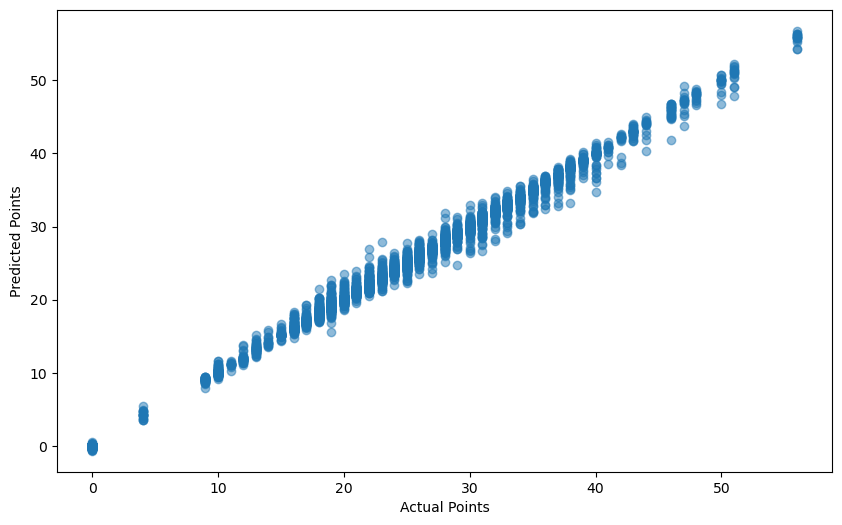

In [111]:
y_pred = best_model.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
m, b = np.polyfit(y, y_pred, 1)

Most definitely overfitted. Just playing around with this model.

In [112]:

player1 = {
    'days_rest': 2,  
    'opponent_pace': 100.5,  
    'lebron_usage_rate': 30.5,  
    'lebron_points_5_game_avg': 25.0, 
    'assists_last_5_avg': 7.0, 
    'rebounds_last_5_avg': 8.0,  
    'efficiency_last_5_avg': 28.0, 
    'opponent_defensive_rating_5_game_avg': 105.0,  
    'opponent_blocks_avg': 5.0,  
    'opponent_steals_avg': 7.0, 
    'opponent_position': 'F', 
    'home_game': 1, 
    'back_to_back_game': False,  
    'lebron_minutes_played': 35.0,  
    'team_offensive_rating': 110.0,  
    'team_defensive_rating': 105.0, 
    'opponent_team_defensive_rating': 108.0,  
    'points_ratio': 1.2,  
    'efficiency_diff': 5,  
    'lebron_fg_pct_vs_opponent_blocks': 50.0, 
    'point_differential_5_game_avg': 3.0,  
    'opponent_current_wolves': 0,  
    'game_officials_exp': 10,  
    'attendance': 19000,  
    'first_game_flag': 1, 
    'playing_lebron_avg_last_5': 1  
}

player2 = {
    'days_rest': 2,  
    'opponent_pace': 100.5,  
    'lebron_usage_rate': 30.5,  
    'lebron_points_5_game_avg': 25.0, 
    'assists_last_5_avg': 7.0, 
    'rebounds_last_5_avg': 8.0,  
    'efficiency_last_5_avg': 28.0, 
    'opponent_defensive_rating_5_game_avg': 105.0,  
    'opponent_blocks_avg': 5.0,  
    'opponent_steals_avg': 7.0, 
    'opponent_position': 'F', 
    'home_game': 1, 
    'back_to_back_game': False,  
    'lebron_minutes_played': 35.0,  
    'team_offensive_rating': 110.0,  
    'team_defensive_rating': 105.0, 
    'opponent_team_defensive_rating': 108.0,  
    'points_ratio': 1.2,  
    'efficiency_diff': 5,  
    'lebron_fg_pct_vs_opponent_blocks': 50.0, 
    'point_differential_5_game_avg': 3.0,  
    'opponent_current_wolves': 0,  
    'game_officials_exp': 10,  
    'attendance': 19000,  
    'first_game_flag': 1, 
    'playing_lebron_avg_last_5': 1  
}

player3 = {
    'days_rest': 2,  
    'opponent_pace': 100.5,  
    'lebron_usage_rate': 30.5,  
    'lebron_points_5_game_avg': 25.0, 
    'assists_last_5_avg': 7.0, 
    'rebounds_last_5_avg': 8.0,  
    'efficiency_last_5_avg': 28.0, 
    'opponent_defensive_rating_5_game_avg': 105.0,  
    'opponent_blocks_avg': 5.0,  
    'opponent_steals_avg': 7.0, 
    'opponent_position': 'F', 
    'home_game': 1, 
    'back_to_back_game': False,  
    'lebron_minutes_played': 35.0,  
    'team_offensive_rating': 110.0,  
    'team_defensive_rating': 105.0, 
    'opponent_team_defensive_rating': 108.0,  
    'points_ratio': 1.2,  
    'efficiency_diff': 5,  
    'lebron_fg_pct_vs_opponent_blocks': 50.0, 
    'point_differential_5_game_avg': 3.0,  
    'opponent_current_wolves': 0,  
    'game_officials_exp': 10,  
    'attendance': 19000,  
    'first_game_flag': 1, 
    'playing_lebron_avg_last_5': 1  
}


player4 = {
    'days_rest': 2,  
    'opponent_pace': 100.5,  
    'lebron_usage_rate': 30.5,  
    'lebron_points_5_game_avg': 25.0, 
    'assists_last_5_avg': 7.0, 
    'rebounds_last_5_avg': 8.0,  
    'efficiency_last_5_avg': 28.0, 
    'opponent_defensive_rating_5_game_avg': 105.0,  
    'opponent_blocks_avg': 5.0,  
    'opponent_steals_avg': 7.0, 
    'opponent_position': 'F', 
    'home_game': 1, 
    'back_to_back_game': False,  
    'lebron_minutes_played': 35.0,  
    'team_offensive_rating': 110.0,  
    'team_defensive_rating': 105.0, 
    'opponent_team_defensive_rating': 108.0,  
    'points_ratio': 1.2,  
    'efficiency_diff': 5,  
    'lebron_fg_pct_vs_opponent_blocks': 50.0, 
    'point_differential_5_game_avg': 3.0,  
    'opponent_current_wolves': 0,  
    'game_officials_exp': 10,  
    'attendance': 19000,  
    'first_game_flag': 1, 
    'playing_lebron_avg_last_5': 1  
}


player5 = {
    'days_rest': 2,  
    'opponent_pace': 100.5,  
    'lebron_usage_rate': 30.5,  
    'lebron_points_5_game_avg': 25.0, 
    'assists_last_5_avg': 7.0, 
    'rebounds_last_5_avg': 8.0,  
    'efficiency_last_5_avg': 28.0, 
    'opponent_defensive_rating_5_game_avg': 105.0,  
    'opponent_blocks_avg': 5.0,  
    'opponent_steals_avg': 7.0, 
    'opponent_position': 'F', 
    'home_game': 1, 
    'back_to_back_game': False,  
    'lebron_minutes_played': 35.0,  
    'team_offensive_rating': 110.0,  
    'team_defensive_rating': 105.0, 
    'opponent_team_defensive_rating': 108.0,  
    'points_ratio': 1.2,  
    'efficiency_diff': 5,  
    'lebron_fg_pct_vs_opponent_blocks': 50.0, 
    'point_differential_5_game_avg': 3.0,  
    'opponent_current_wolves': 0,  
    'game_officials_exp': 10,  
    'attendance': 19000,  
    'first_game_flag': 1, 
    'playing_lebron_avg_last_5': 1  
}




predicted_points1 = predict_lebron_points(**player2)
predicted_points2 = predict_lebron_points(**player2)
predicted_points3 = predict_lebron_points(**player2)
predicted_points4 = predict_lebron_points(**player2)
predicted_points5 = predict_lebron_points(**player2)

avg_points = (predicted_points1 + predicted_points2 + predicted_points3 + predicted_points4 + predicted_points5) / 5

print(f"Predicted Points for LeBron James on October 22nd: {avg_points}")

Predicted Points for LeBron James on October 22nd: 30.43858947753906
